### Implémentez un modèle de scoring

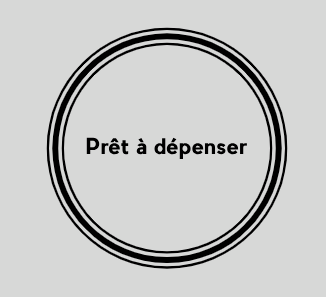

L’entreprise souhaite **mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité** qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un **algorithme de classification** en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de **transparence** des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

**Prêt à dépenser** décide donc de **développer un dashboard interactif** pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

Dans ce notebook, nous présentons nos analyses exploratoires et nos premiers tests en machine learning.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_row', 130)
pd.set_option('display.max_column', 130)

In [2]:
df_application_train = pd.read_csv('/Users/Badri47/Desktop/P7/DATA/application_train.csv')
df_application_test = pd.read_csv('/Users/Badri47/Desktop/P7/DATA/application_test.csv')

df_bureau = pd.read_csv('/Users/Badri47/Desktop/P7/DATA/bureau.csv')
df_bureau_balance = pd.read_csv('/Users/Badri47/Desktop/P7/DATA/bureau_balance.csv')
df_POS_CASH_balance = pd.read_csv('/Users/Badri47/Desktop/P7/DATA/POS_CASH_balance.csv')
df_credit_card_balance = pd.read_csv('/Users/Badri47/Desktop/P7/DATA/credit_card_balance.csv')
df_previous_application = pd.read_csv('/Users/Badri47/Desktop/P7/DATA/previous_application.csv')
df_installments_payments = pd.read_csv('/Users/Badri47/Desktop/P7/DATA/installments_payments.csv')

df_HomeCredit_columns_description = pd.read_csv('/Users/Badri47/Desktop/P7/DATA/HomeCredit_columns_description.csv', encoding='cp1252', index_col=0)


**application_{train|test}.csv :**
This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

**bureau.csv :**
All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

**bureau_balance.csv :**
Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

**POS_CASH_balance.csv :**
Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

**credit_card_balance.csv :**
Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

**previous_application.csv :**
All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

**installments_payments.csv :**
Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

**HomeCredit_columns_description.csv :**
This file contains descriptions for the columns in the various data files.

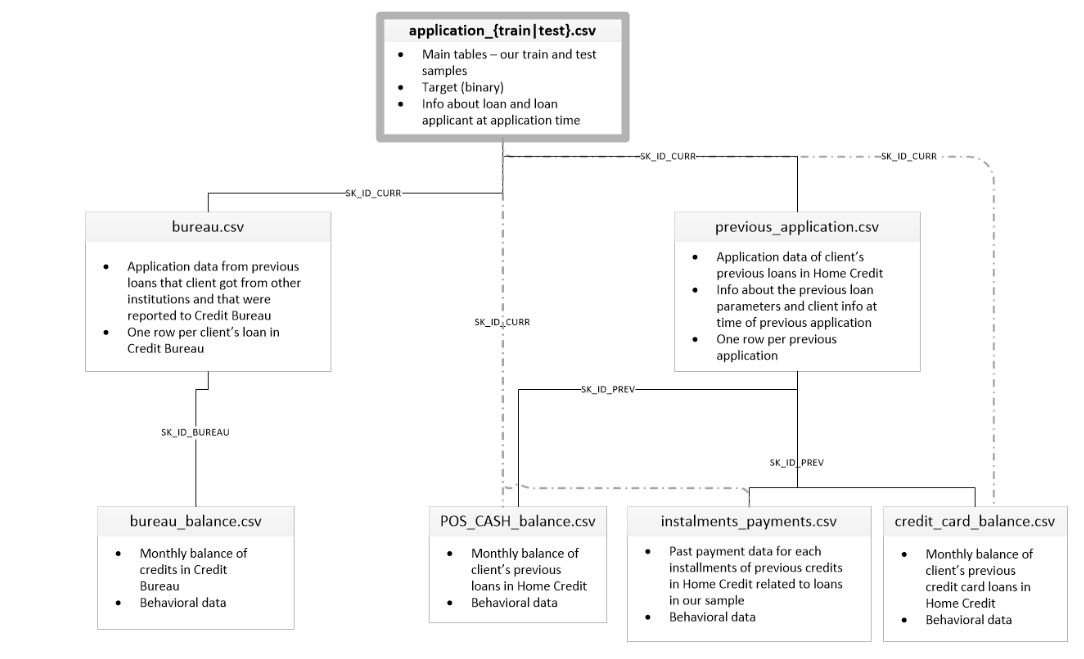

In [3]:
liste_df = [df_application_train,df_application_test,df_bureau,df_bureau_balance,df_POS_CASH_balance,df_credit_card_balance,df_previous_application,df_installments_payments,df_HomeCredit_columns_description]

liste = ['application_train', 'application_test','bureau','bureau_balance','POS_CASH_balance','credit_card_balance','previous_application','installments_payments','HomeCredit_columns_description']

for df, name in zip(liste_df, liste) :
   print(name, df.shape)

application_train (307511, 122)
application_test (48744, 121)
bureau (1716428, 17)
bureau_balance (27299925, 3)
POS_CASH_balance (10001358, 8)
credit_card_balance (3840312, 23)
previous_application (1670214, 37)
installments_payments (13605401, 8)
HomeCredit_columns_description (219, 4)


In [4]:
for df, name in zip(liste_df, liste) :
  print("Dataframe name :" + name)
  print("Part de NaN :", (df.isna().sum().sum()*100)/(df.shape[0]*df.shape[1]), '%')
  print(((df.isna().sum()/df.shape[0]) * 100),"\n")

Dataframe name :application_train
Part de NaN : 24.395941907129433 %
SK_ID_CURR                       0.000000
TARGET                           0.000000
NAME_CONTRACT_TYPE               0.000000
CODE_GENDER                      0.000000
FLAG_OWN_CAR                     0.000000
FLAG_OWN_REALTY                  0.000000
CNT_CHILDREN                     0.000000
AMT_INCOME_TOTAL                 0.000000
AMT_CREDIT                       0.000000
AMT_ANNUITY                      0.003902
AMT_GOODS_PRICE                  0.090403
NAME_TYPE_SUITE                  0.420148
NAME_INCOME_TYPE                 0.000000
NAME_EDUCATION_TYPE              0.000000
NAME_FAMILY_STATUS               0.000000
NAME_HOUSING_TYPE                0.000000
REGION_POPULATION_RELATIVE       0.000000
DAYS_BIRTH                       0.000000
DAYS_EMPLOYED                    0.000000
DAYS_REGISTRATION                0.000000
DAYS_ID_PUBLISH                  0.000000
OWN_CAR_AGE                     65.990810
FLAG_MO

Part de NaN : 13.502552290879322 %
SK_ID_CURR                 0.000000
SK_ID_BUREAU               0.000000
CREDIT_ACTIVE              0.000000
CREDIT_CURRENCY            0.000000
DAYS_CREDIT                0.000000
CREDIT_DAY_OVERDUE         0.000000
DAYS_CREDIT_ENDDATE        6.149573
DAYS_ENDDATE_FACT         36.916958
AMT_CREDIT_MAX_OVERDUE    65.513264
CNT_CREDIT_PROLONG         0.000000
AMT_CREDIT_SUM             0.000757
AMT_CREDIT_SUM_DEBT       15.011932
AMT_CREDIT_SUM_LIMIT      34.477415
AMT_CREDIT_SUM_OVERDUE     0.000000
CREDIT_TYPE                0.000000
DAYS_CREDIT_UPDATE         0.000000
AMT_ANNUITY               71.473490
dtype: float64 

Dataframe name :bureau_balance
Part de NaN : 0.0 %
SK_ID_BUREAU      0.0
MONTHS_BALANCE    0.0
STATUS            0.0
dtype: float64 

Dataframe name :POS_CASH_balance
Part de NaN : 0.06518864738168556 %
SK_ID_PREV               0.000000
SK_ID_CURR               0.000000
MONTHS_BALANCE           0.000000
CNT_INSTALMENT           0.2606

In [5]:
df_application_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [6]:
description_application  = df_HomeCredit_columns_description[(df_HomeCredit_columns_description.Table == "application_{train|test}.csv")]
description_application                                                          

Table                           Row  \
1    application_{train|test}.csv                    SK_ID_CURR   
2    application_{train|test}.csv                        TARGET   
5    application_{train|test}.csv            NAME_CONTRACT_TYPE   
6    application_{train|test}.csv                   CODE_GENDER   
7    application_{train|test}.csv                  FLAG_OWN_CAR   
8    application_{train|test}.csv               FLAG_OWN_REALTY   
9    application_{train|test}.csv                  CNT_CHILDREN   
10   application_{train|test}.csv              AMT_INCOME_TOTAL   
11   application_{train|test}.csv                    AMT_CREDIT   
12   application_{train|test}.csv                   AMT_ANNUITY   
13   application_{train|test}.csv               AMT_GOODS_PRICE   
14   application_{train|test}.csv               NAME_TYPE_SUITE   
15   application_{train|test}.csv              NAME_INCOME_TYPE   
16   application_{train|test}.csv           NAME_EDUCATION_TYPE   
17   application_{train|test}.csv            NAME_FAMILY_STATUS   
18   application_{train|test}.csv             NAME_HOUSING_TYPE   
19   application_{train|test}.csv    REGION_POPULATION_RELATIVE   
20   application_{train|test}.csv                    DAYS_BIRTH   
21   application_{train|test}.csv                 DAYS_EMPLOYED   
22   application_{train|test}.csv             DAYS_REGISTRATION   
23   application_{train|test}.csv               DAYS_ID_PUBLISH   
24   application_{train|test}.csv                   OWN_CAR_AGE   
25   application_{train|test}.csv                    FLAG_MOBIL   
26   application_{train|test}.csv                FLAG_EMP_PHONE   
27   application_{train|test}.csv               FLAG_WORK_PHONE   
28   application_{train|test}.csv              FLAG_CONT_MOBILE   
29   application_{train|test}.csv                    FLAG_PHONE   
30   application_{train|test}.csv                    FLAG_EMAIL   
31   application_{train|test}.csv               OCCUPATION_TYPE   
32   application_{train|test}.csv               CNT_FAM_MEMBERS   
33   application_{train|test}.csv          REGION_RATING_CLIENT   
34   application_{train|test}.csv   REGION_RATING_CLIENT_W_CITY   
35   application_{train|test}.csv    WEEKDAY_APPR_PROCESS_START   
36   application_{train|test}.csv       HOUR_APPR_PROCESS_START   
37   application_{train|test}.csv    REG_REGION_NOT_LIVE_REGION   
38   application_{train|test}.csv    REG_REGION_NOT_WORK_REGION   
39   application_{train|test}.csv   LIVE_REGION_NOT_WORK_REGION   
40   application_{train|test}.csv        REG_CITY_NOT_LIVE_CITY   
41   application_{train|test}.csv        REG_CITY_NOT_WORK_CITY   
42   application_{train|test}.csv       LIVE_CITY_NOT_WORK_CITY   
43   application_{train|test}.csv             ORGANIZATION_TYPE   
44   application_{train|test}.csv                  EXT_SOURCE_1   
45   application_{train|test}.csv                  EXT_SOURCE_2   
46   application_{train|test}.csv                  EXT_SOURCE_3   
47   application_{train|test}.csv                APARTMENTS_AVG   
48   application_{train|test}.csv              BASEMENTAREA_AVG   
49   application_{train|test}.csv   YEARS_BEGINEXPLUATATION_AVG   
50   application_{train|test}.csv               YEARS_BUILD_AVG   
51   application_{train|test}.csv                COMMONAREA_AVG   
52   application_{train|test}.csv                 ELEVATORS_AVG   
53   application_{train|test}.csv                 ENTRANCES_AVG   
54   application_{train|test}.csv                 FLOORSMAX_AVG   
55   application_{train|test}.csv                 FLOORSMIN_AVG   
56   application_{train|test}.csv                  LANDAREA_AVG   
57   application_{train|test}.csv          LIVINGAPARTMENTS_AVG   
58   application_{train|test}.csv                LIVINGAREA_AVG   
59   application_{train|test}.csv       NONLIVINGAPARTMENTS_AVG   
60   application_{train|test}.csv             NONLIVINGAREA_AVG   
61   application_{train|test}.csv               APARTMENTS_MODE   
62   app

### Feature engineering

Code pris en parti sur le kaggle [**AGUIAR**](https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script).

Permet la simplification et la création de nouvelles variables comme 'DAYS_EMPLOYED_PERC' ou 'INCOME_CREDIT_PERC'.

Encode également les features quand nécéssaire.

In [7]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = df_application_train
    test_df = df_application_test
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
        df[bin_feature] = df[bin_feature].astype('category')

    for cat_feature in ['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY',
                        'AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON',
                        'AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR',
                       ] :
        df[cat_feature] = df[cat_feature].astype('category')

    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    df[cat_cols] = df[cat_cols].astype('category')
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    df.drop(columns= ['index'], inplace= True)
    df['TARGET'] = df['TARGET'].astype('category')

    for doc in range(2,22) :
        df['FLAG_DOCUMENT_{0}'.format(doc)] = df['FLAG_DOCUMENT_{0}'.format(doc)].astype('category')
    
    for cat_feature in [ 'FLAG_MOBIL', 'FLAG_EMP_PHONE',	'FLAG_WORK_PHONE',
                        'FLAG_CONT_MOBILE',	'FLAG_PHONE',	'FLAG_EMAIL'] :
        df[cat_feature] = df[cat_feature].astype('category')

    del test_df
    gc.collect()
    return df

In [8]:
df = application_train_test()
df.head()

Train samples: 307511, test samples: 48744


SK_ID_CURR TARGET CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0      100002    1.0           0            0               0             0   
1      100003    0.0           1            0               1             0   
2      100004    0.0           0            1               0             0   
3      100006    0.0           1            0               0             0   
4      100007    0.0           0            0               0             0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          202500.0    406597.5      24700.5         351000.0   
1          270000.0   1293502.5      35698.5        1129500.0   
2           67500.0    135000.0       6750.0         135000.0   
3          135000.0    312682.5      29686.5         297000.0   
4          121500.0    513000.0      21865.5         513000.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461         -637.0            -3648.0   
1                    0.003541      -16765        -1188.0            -1186.0   
2                    0.010032      -19046         -225.0            -4260.0   
3                    0.008019      -19005        -3039.0            -9833.0   
4                    0.028663      -19932        -3038.0            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE FLAG_MOBIL FLAG_EMP_PHONE FLAG_WORK_PHONE  \
0            -2120          NaN          1              1               0   
1             -291          NaN          1              1               0   
2            -2531         26.0          1              1               1   
3            -2437          NaN          1              1               0   
4            -3458          NaN          1              1               0   

  FLAG_CONT_MOBILE FLAG_PHONE FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                1          1          0              1.0   
1                1          1          0              2.0   
2                1          1          0              1.0   
3                1          0          0              2.0   
4                1          0          0              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                            2                       10   
1                     1                            1                       11   
2                     2                            2                        9   
3                     2                            2                       17   
4                     2                            2                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0      0.083037   
1                       0                        0      0.311267   
2                       0                        0           NaN   
3                       0                        0           NaN   
4                       1                        1           NaN   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.262949      0.139376          0.0247            0.0369   
1      0.622246           NaN          0.0959            0.0529   
2      0.555912    

In [9]:
df.shape

(356251, 247)

In [10]:
df.dtypes

SK_ID_CURR                int64
TARGET                 category
CODE_GENDER            category
FLAG_OWN_CAR           category
FLAG_OWN_REALTY        category
                         ...   
DAYS_EMPLOYED_PERC      float64
INCOME_CREDIT_PERC      float64
INCOME_PER_PERSON       float64
ANNUITY_INCOME_PERC     float64
PAYMENT_RATE            float64
Length: 247, dtype: object

In [11]:
limitPer = len(df) * .80
df.dropna(thresh=limitPer, axis=1, inplace=True)
df_train = df.loc[df['TARGET'].isna() == False]
df_test = df.loc[df['TARGET'].isna()]
df_train.dropna(inplace=True)

### Analyse Exploratoire

In [12]:
df.shape

(356251, 202)

In [13]:
df.head(5)

SK_ID_CURR TARGET CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0      100002    1.0           0            0               0             0   
1      100003    0.0           1            0               1             0   
2      100004    0.0           0            1               0             0   
3      100006    0.0           1            0               0             0   
4      100007    0.0           0            0               0             0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          202500.0    406597.5      24700.5         351000.0   
1          270000.0   1293502.5      35698.5        1129500.0   
2           67500.0    135000.0       6750.0         135000.0   
3          135000.0    312682.5      29686.5         297000.0   
4          121500.0    513000.0      21865.5         513000.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461         -637.0            -3648.0   
1                    0.003541      -16765        -1188.0            -1186.0   
2                    0.010032      -19046         -225.0            -4260.0   
3                    0.008019      -19005        -3039.0            -9833.0   
4                    0.028663      -19932        -3038.0            -4311.0   

   DAYS_ID_PUBLISH FLAG_MOBIL FLAG_EMP_PHONE FLAG_WORK_PHONE FLAG_CONT_MOBILE  \
0            -2120          1              1               0                1   
1             -291          1              1               0                1   
2            -2531          1              1               1                1   
3            -2437          1              1               0                1   
4            -3458          1              1               0                1   

  FLAG_PHONE FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0          1          0              1.0                     2   
1          1          0              2.0                     1   
2          1          0              1.0                     2   
3          0          0              2.0                     2   
4          0          0              1.0                     2   

   REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                            2                       10   
1                            1                       11   
2                            2                        9   
3                            2                       17   
4                            2                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_2  \
0                       0                        0      0.262949   
1                       0                        0      0.622246   
2                       0                        0      0.555912   
3                       0                        0      0.650442   
4                       1                        1      0.322738   

   EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
0      0.139376                       2.0                       2.0   
1           NaN                       1.0                       0.0   
2      0.729567                       0.0                       0.0   
3           Na

In [14]:
df.describe()

SK_ID_CURR   CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count  356251.000000  356251.000000      3.562510e+05  3.562510e+05   
mean   278128.870078       0.414312      1.701159e+05  5.877695e+05   
std    102842.068890       0.720376      2.235080e+05  3.986253e+05   
min    100001.000000       0.000000      2.565000e+04  4.500000e+04   
25%    189065.500000       0.000000      1.125000e+05  2.700000e+05   
50%    278129.000000       0.000000      1.530000e+05  5.002110e+05   
75%    367192.500000       1.000000      2.025000e+05  7.975575e+05   
max    456255.000000      20.000000      1.170000e+08  4.050000e+06   

         AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
count  356215.000000     3.559730e+05               356251.000000   
mean    27425.644390     5.280212e+05                    0.020917   
std     14732.860946     3.660657e+05                    0.013915   
min      1615.500000     4.050000e+04                    0.000253   
25%     16731.000000     2.340000e+05                    0.010006   
50%     25078.500000     4.500000e+05                    0.018850   
75%     34960.500000     6.750000e+05                    0.028663   
max    258025.500000     4.050000e+06                    0.072508   

          DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
count  356251.000000  291603.000000      356251.000000    356251.000000   
mean   -16041.276687   -2396.675703       -4983.603036     -3002.070644   
std      4358.798530    2334.451895        3526.966202      1517.905393   
min    -25229.000000  -17912.000000      -24672.000000     -7197.000000   
25%    -19676.000000   -3200.000000       -7477.000000     -4318.000000   
50%    -15755.000000   -1663.000000       -4502.000000     -3252.000000   
75%    -12425.000000    -780.000000       -1995.000000     -1717.000000   
max     -7338.000000       0.000000           0.000000         0.000000   

       CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
count    356249.000000         356251.000000                356251.000000   
mean          2.151852              2.050504                     2.028929   
std           0.907936              0.510948                     0.504586   
min           1.000000              1.000000                    -1.000000   
25%           2.000000              2.000000                     2.000000   
50%           2.000000              2.000000                     2.000000   
75%           3.000000              2.000000                     2.000000   
max          21.000000              3.000000                     3.000000   

       HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
count            356251.000000               356251.000000   
mean                 12.055728                    0.015649   
std                   3.267578                    0.124114   
min                   0.000000                    0.000000   
25%                  10.000000                    0.000000   
50%                  12.000000                    0.000000   
75%                  14.000000                    0.000000   
max                  23.000000                    1.000000   

       REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
count               356251.000000                356251.000000   
mean                     0.051371                     0.040848   
std                      0.220754                     0.197937   
min                      0.000000                     0.000000   
25%                      0.000000                     0.000000   
50%                      0.000000                     0.000000   
75%                      0.000000                     0.000000   
max                      1.000000                     1.000000   

       REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
count           356251.000000           356251.000000   
mean                 0.078077                0.229664   
std                  0.268293                0.420617

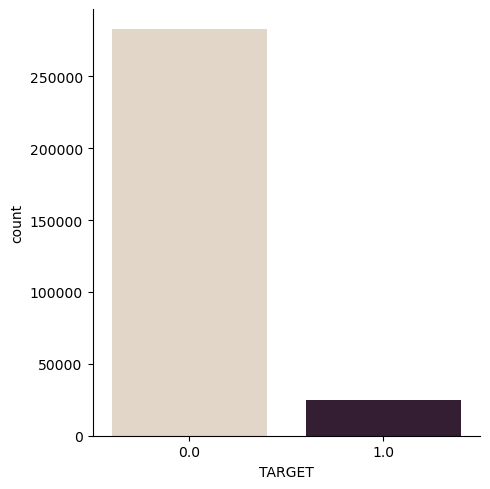

In [15]:
sns.catplot(x="TARGET", kind="count", palette="ch:.25", data=df)

In [16]:
df['TARGET'].value_counts()

0.0    282682
1.0     24825
Name: TARGET, dtype: int64

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.
Note: The number of non binary numerical features is very large (27), please consider splitting the data. Showing plots for the first 20 numerical features. Override this by setting showall=True.


<AxesSubplot: xlabel='OBS_60_CNT_SOCIAL_CIRCLE', ylabel='Density'>

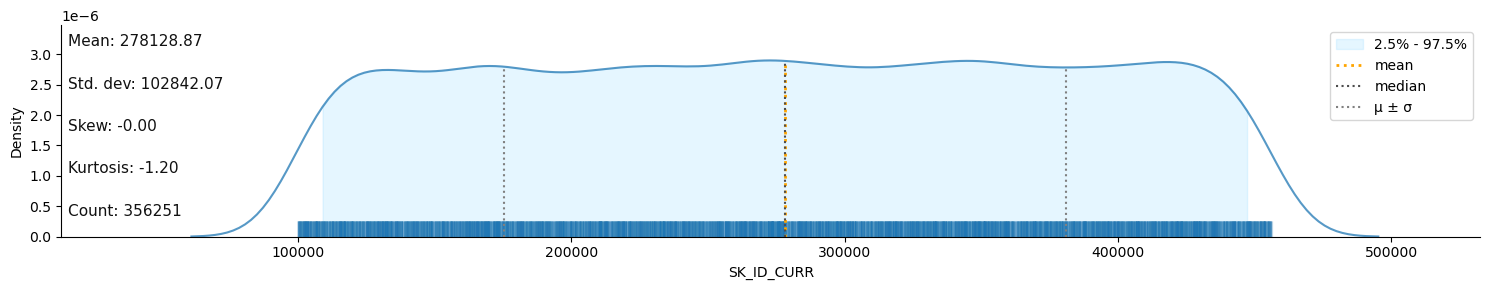

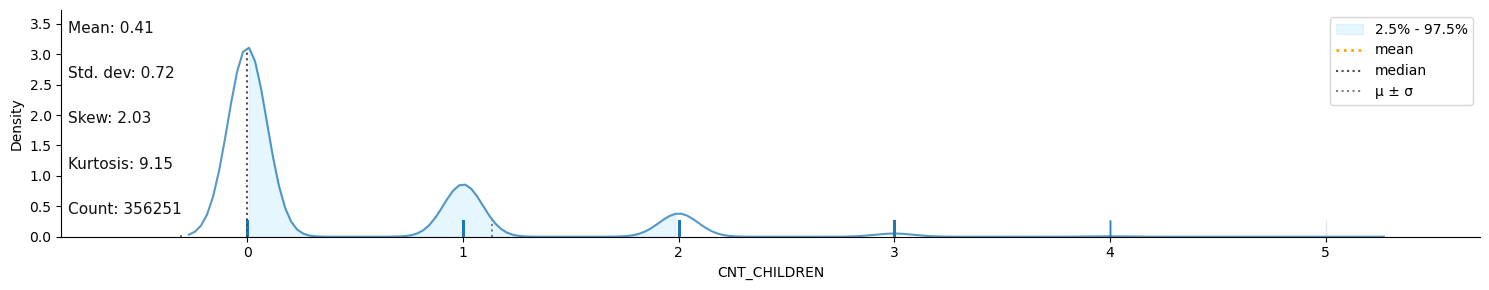

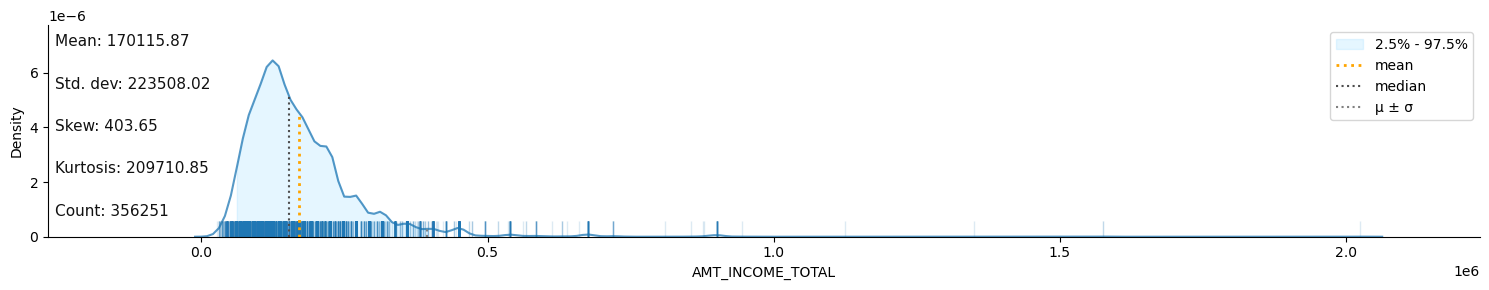

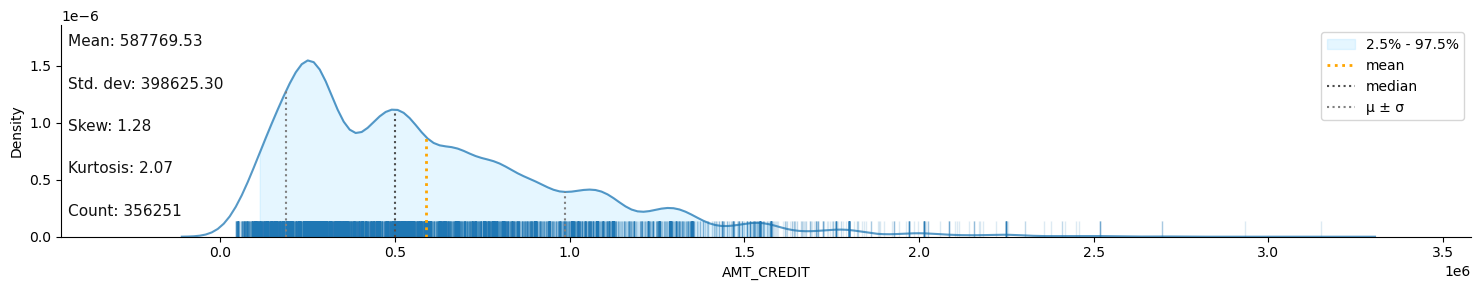

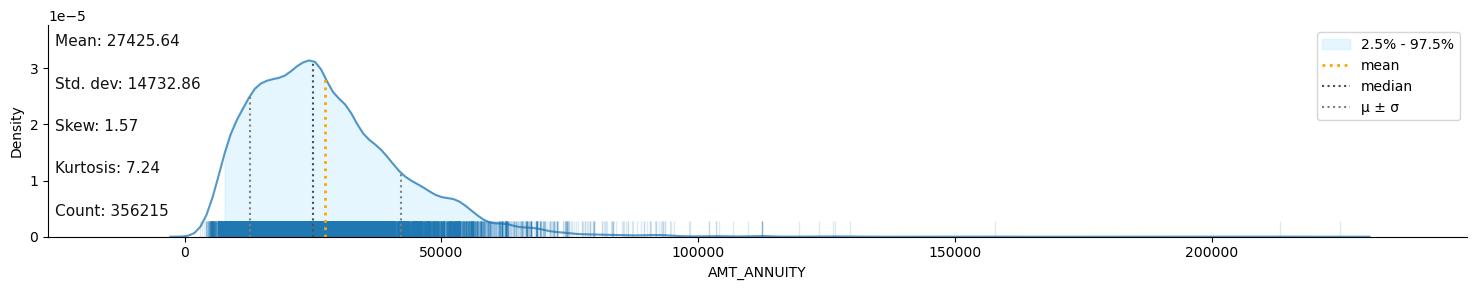

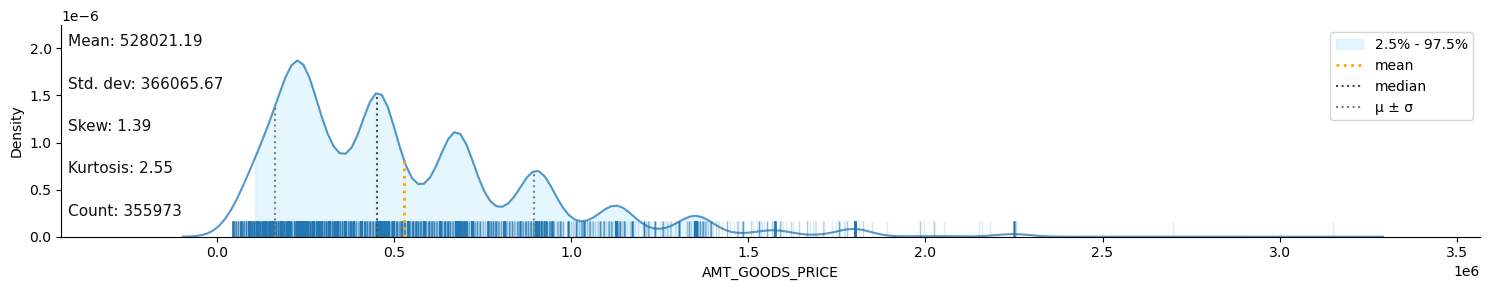

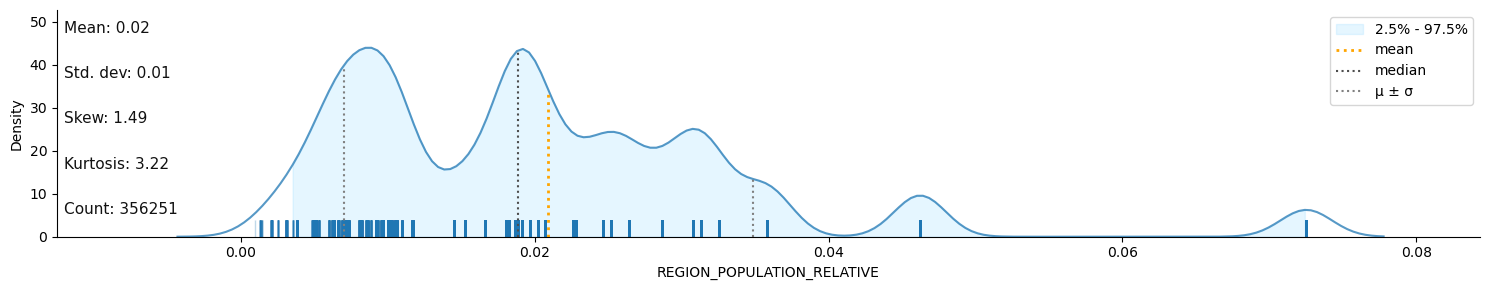

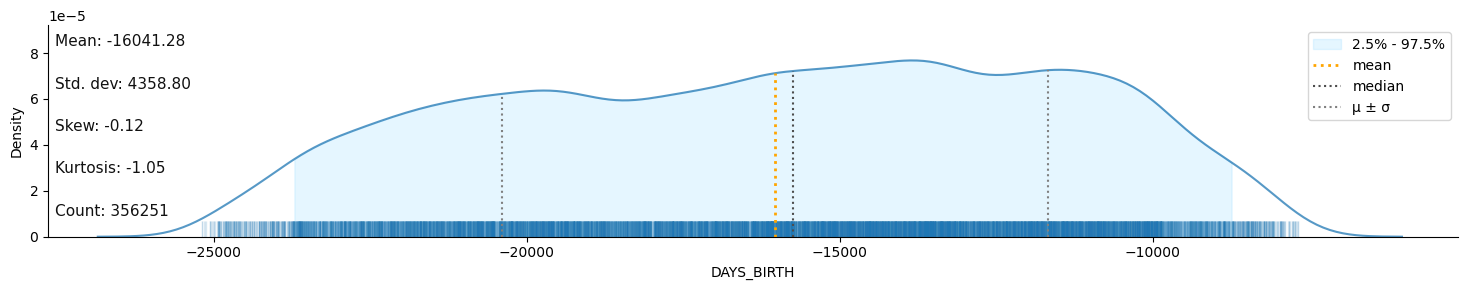

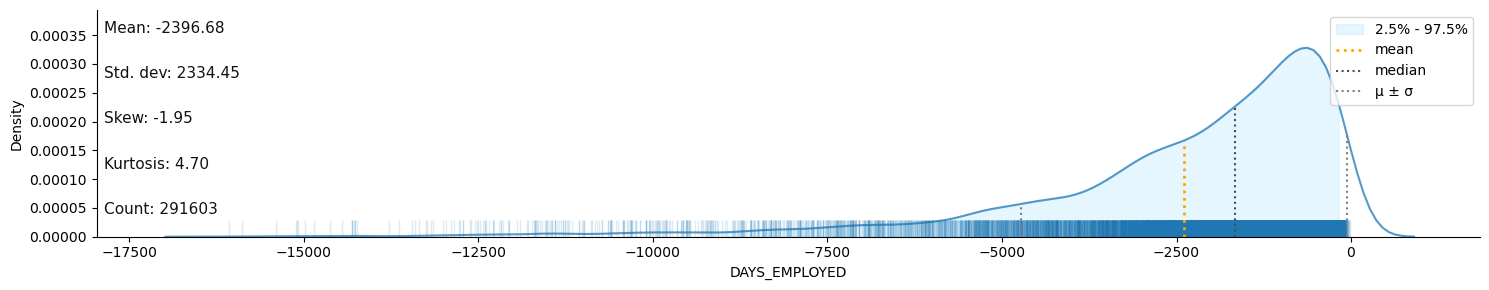

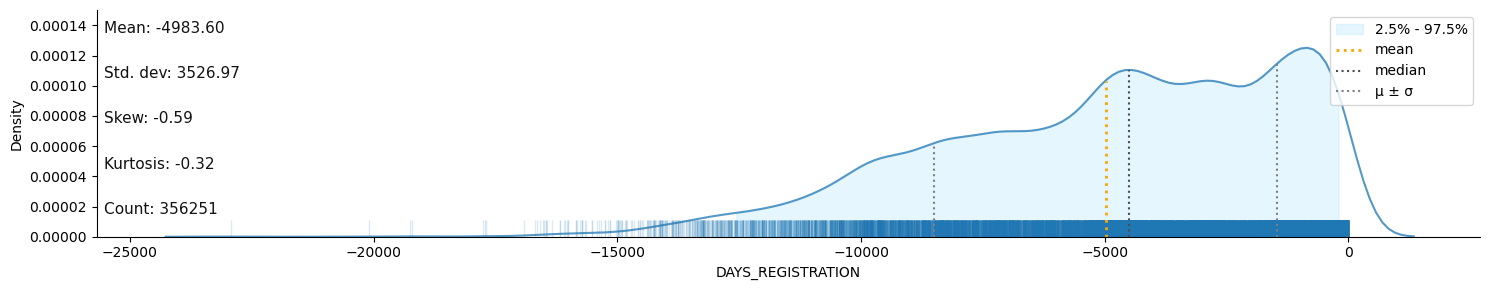

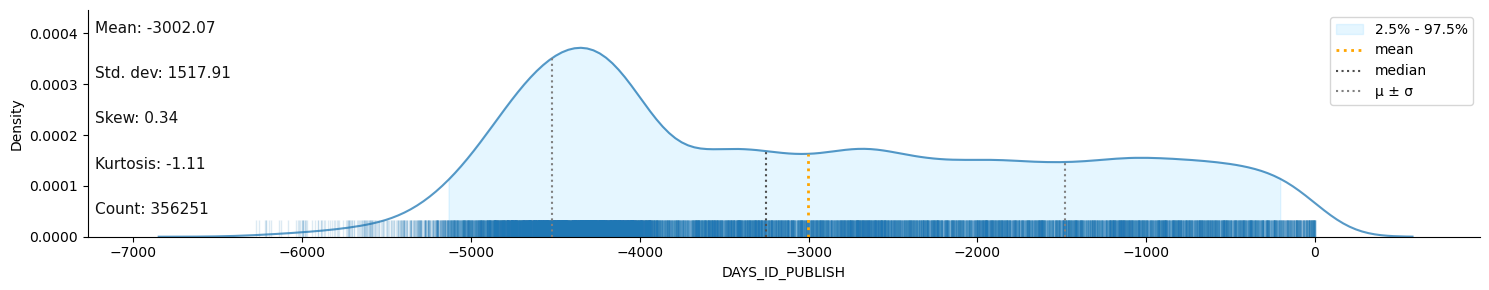

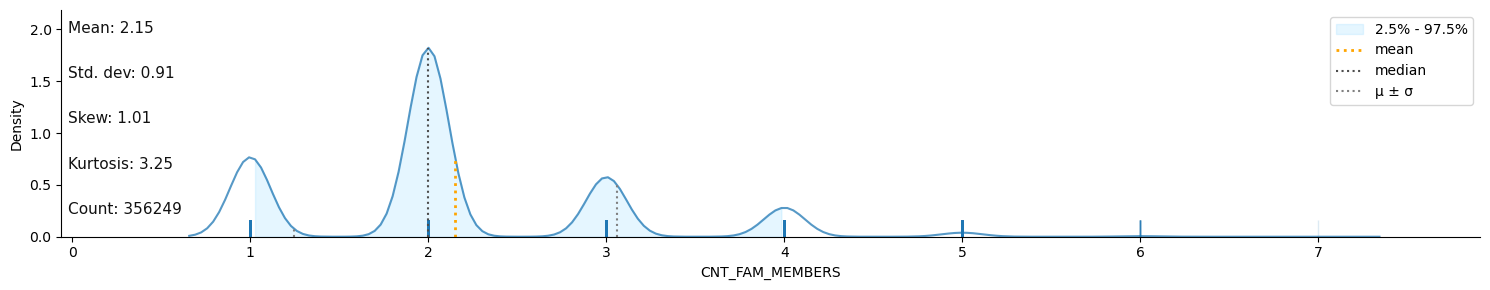

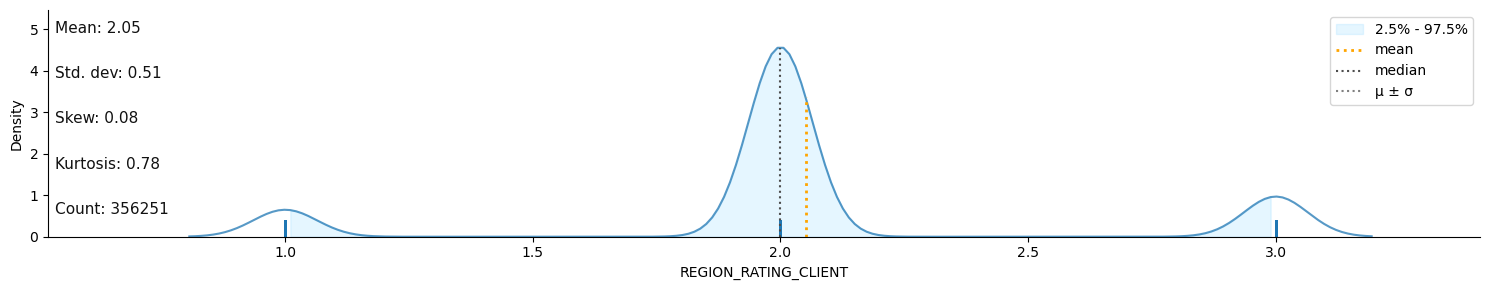

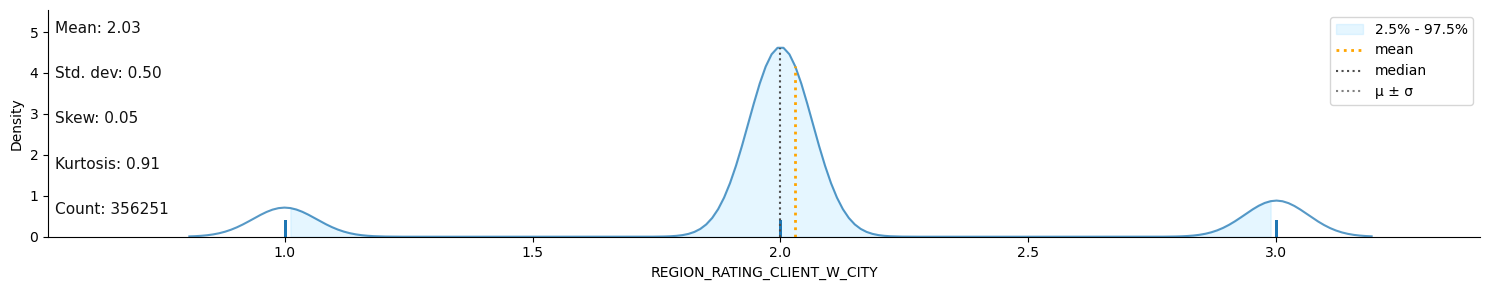

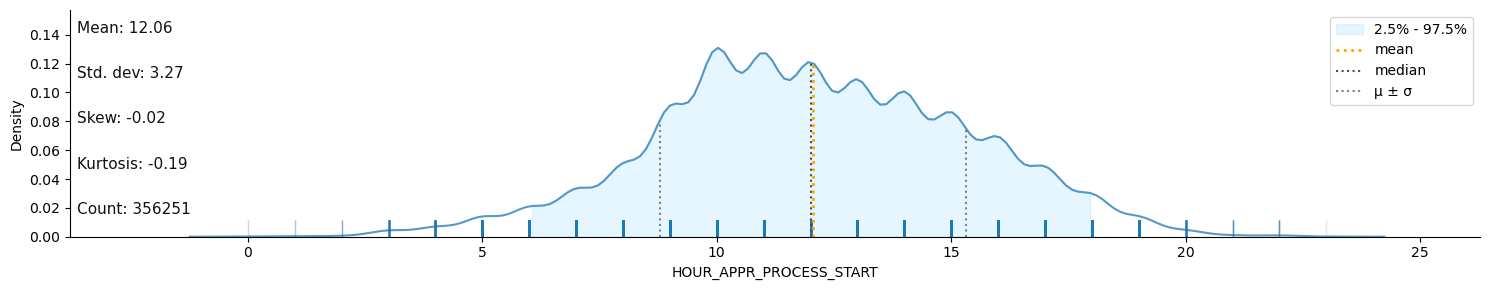

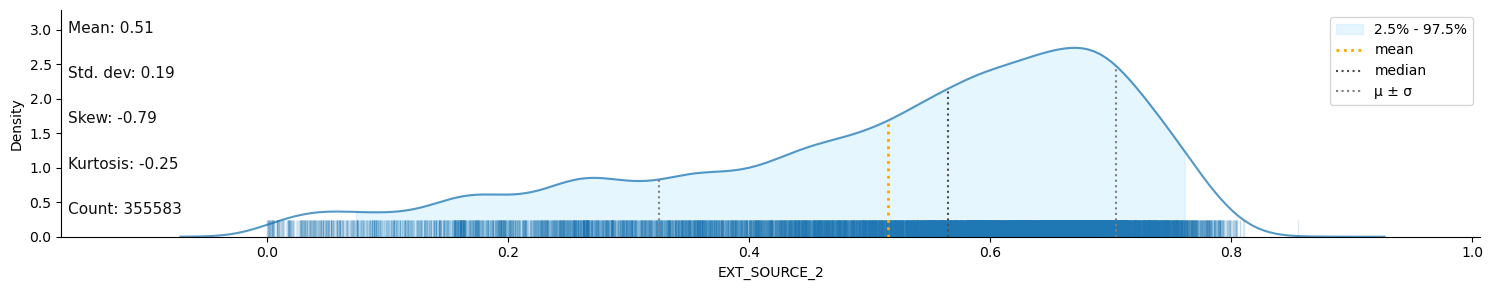

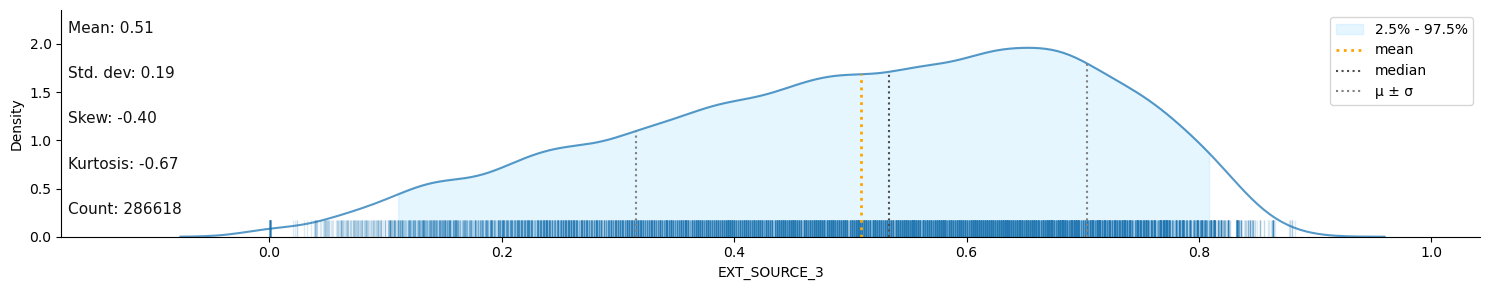

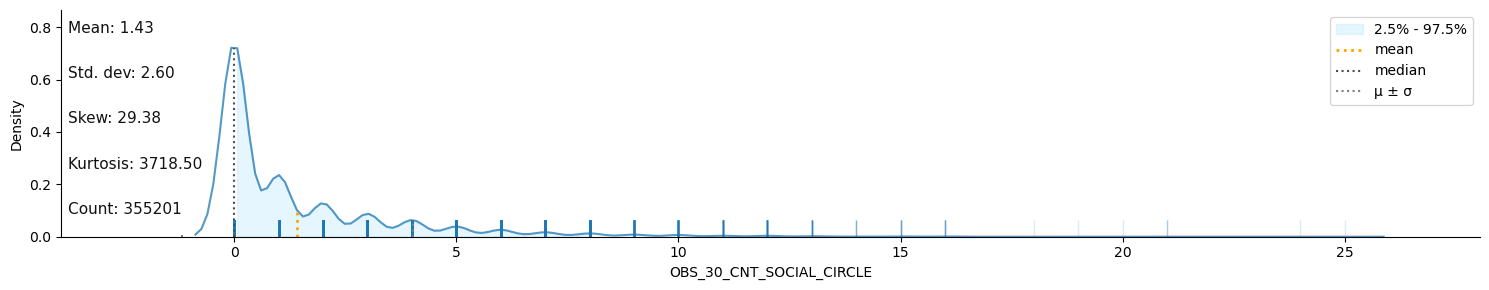

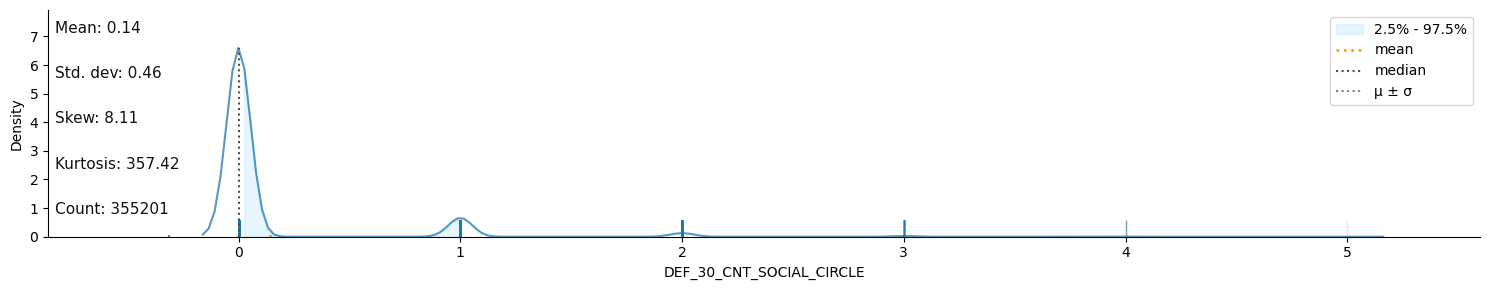

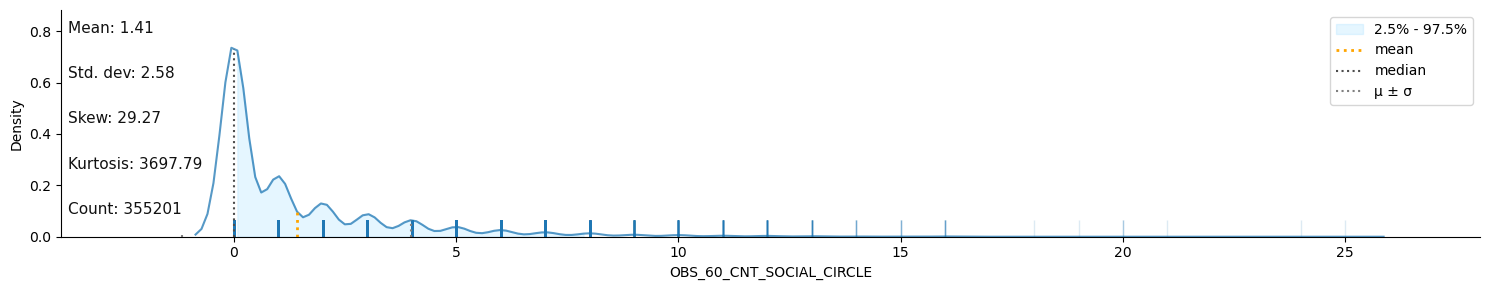

In [17]:
numeric_cols = df.select_dtypes(include=['float64','int64']).columns

import klib as kl

kl.dist_plot(df[numeric_cols])

In [18]:
from scipy.stats import f_oneway
numeric_cols = df_train.select_dtypes(include=['float64','int64']).columns

# Running the one-way anova test between CarPrice and FuelTypes
# Assumption(H0) is that FuelType and CarPrices are NOT correlated
for num in numeric_cols :
# Finds out the Prices data for each FuelType as a list
  df_gb=df_train.groupby('TARGET')[num].apply(list)
  # Performing the ANOVA test
  # We accept the Assumption(H0) only when P-Value &gt; 0.05
  AnovaResults = f_oneway(*df_gb)
  print('P-Value for Anova is with column = {0}: '.format(num), AnovaResults[1])

P-Value for Anova is with column = SK_ID_CURR:  0.1273875167512271
P-Value for Anova is with column = CNT_CHILDREN:  0.00013572608093377213
P-Value for Anova is with column = AMT_INCOME_TOTAL:  0.09890205586563255
P-Value for Anova is with column = AMT_CREDIT:  2.9229935080286446e-67
P-Value for Anova is with column = AMT_ANNUITY:  1.0826448886647728e-18
P-Value for Anova is with column = AMT_GOODS_PRICE:  3.395330689849609e-103
P-Value for Anova is with column = REGION_POPULATION_RELATIVE:  4.016873654296159e-61
P-Value for Anova is with column = DAYS_BIRTH:  1.184651462756636e-200
P-Value for Anova is with column = DAYS_EMPLOYED:  1.4556973960429756e-248
P-Value for Anova is with column = DAYS_REGISTRATION:  1.6382582555041345e-56
P-Value for Anova is with column = DAYS_ID_PUBLISH:  1.6415532261235462e-65
P-Value for Anova is with column = CNT_FAM_MEMBERS:  0.617392861443196
P-Value for Anova is with column = REGION_RATING_CLIENT:  3.3350217134493196e-158
P-Value for Anova is with co

In [19]:
import re

# Boucle sur les colonnes du dataframe
for col in df.columns:
    # Remplace les caractères spéciaux par des _
    new_col = re.sub('[^0-9a-zA-Z_]+', '_', col)
    # Renomme la colonne
    df.rename(columns={col: new_col}, inplace=True)

In [20]:
df_train = df.loc[df['TARGET'].isna() == False]
df_pred = df.loc[df['TARGET'].isna()]

df_train.drop(columns = ['SK_ID_CURR'], inplace= True)
# dfgb = df.groupby('TARGET')

In [21]:
df_train.dtypes

TARGET                 category
CODE_GENDER            category
FLAG_OWN_CAR           category
FLAG_OWN_REALTY        category
CNT_CHILDREN              int64
                         ...   
DAYS_EMPLOYED_PERC      float64
INCOME_CREDIT_PERC      float64
INCOME_PER_PERSON       float64
ANNUITY_INCOME_PERC     float64
PAYMENT_RATE            float64
Length: 201, dtype: object

<AxesSubplot: title={'center': 'Feature-correlation (pearson)'}>

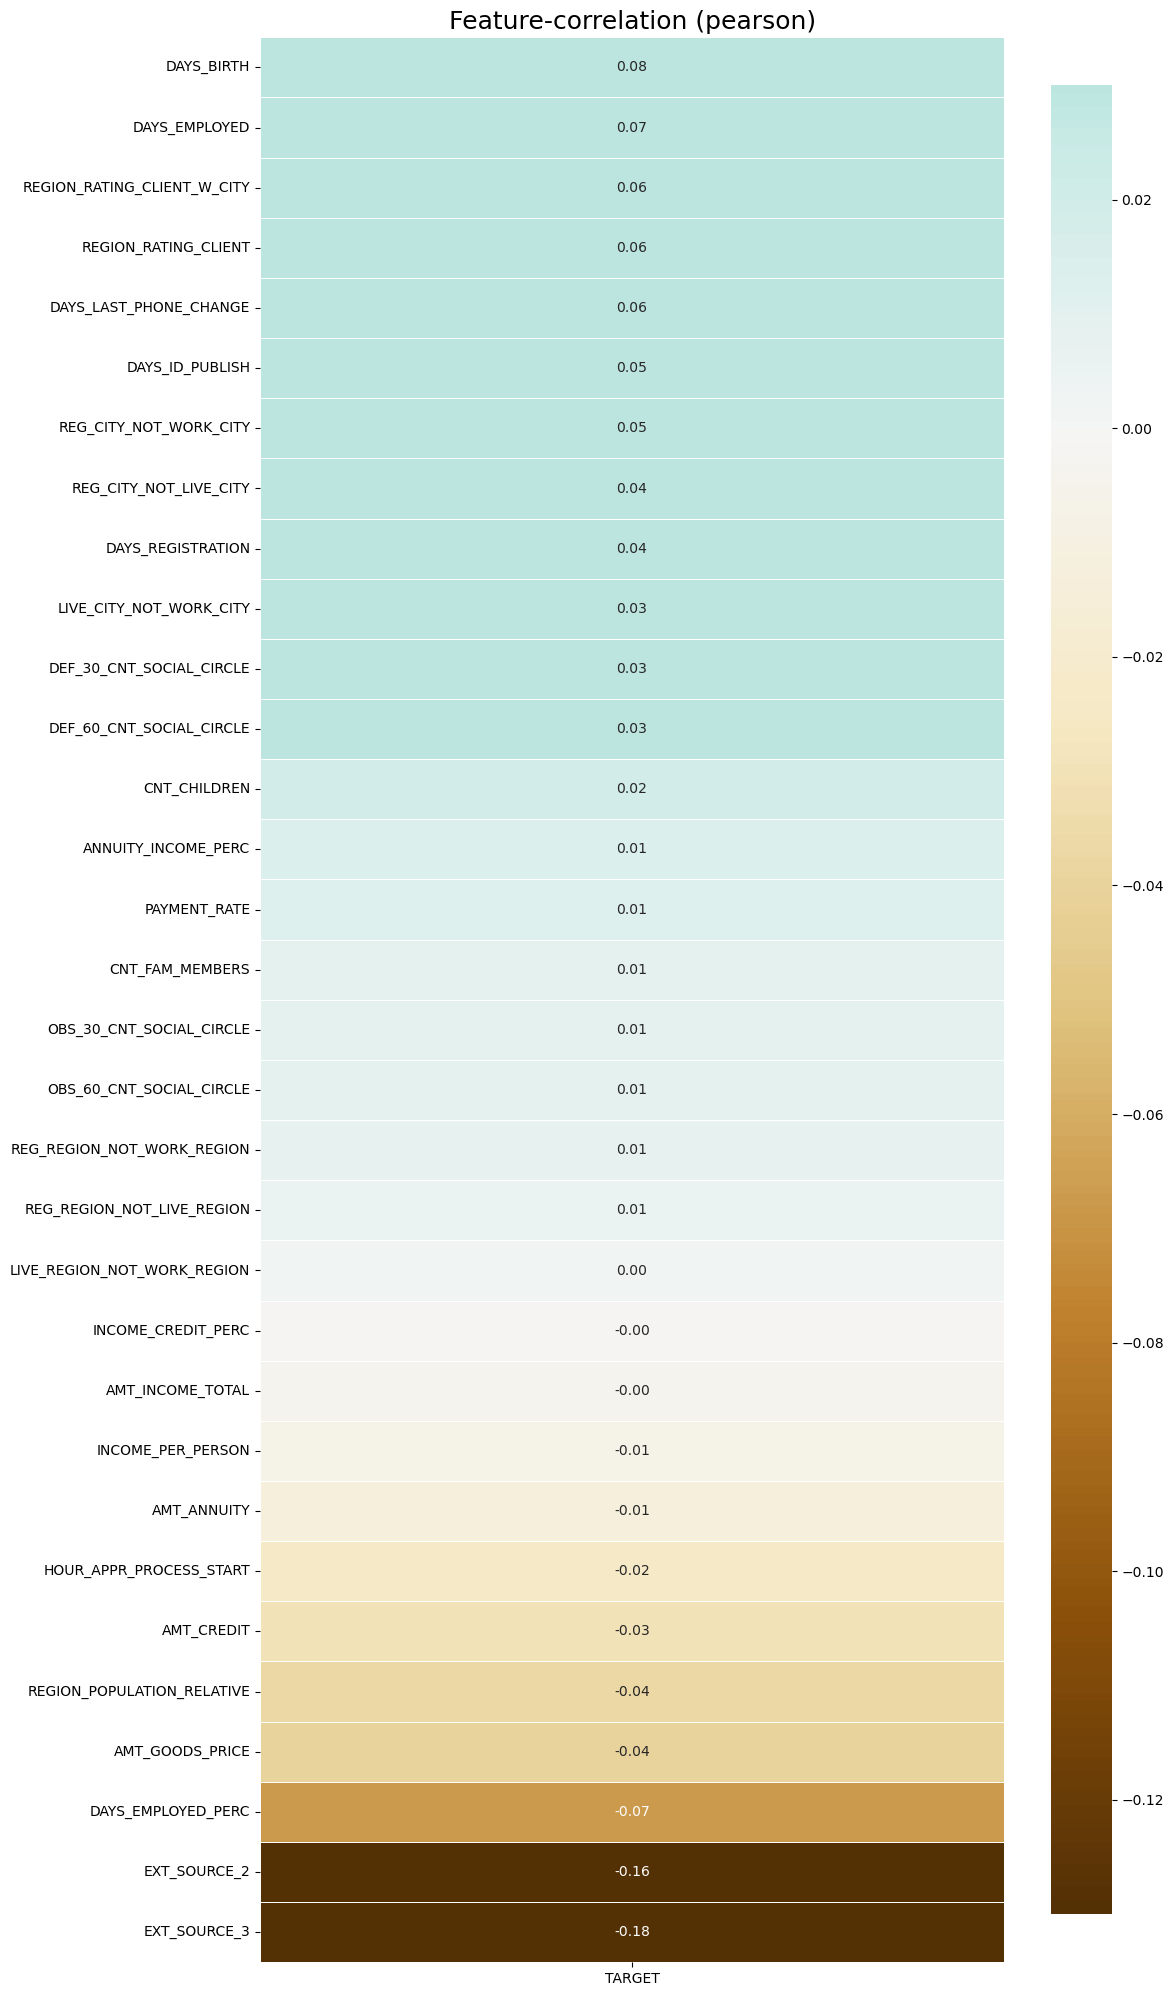

In [22]:
kl.corr_plot(df_train, target='TARGET', figsize=(12, 25))

In [23]:
print(pd.__version__)

1.5.3


In [24]:
print(kl.__version__)

1.0.7


In [25]:
print(np.__version__)

1.23.5


<AxesSubplot: xlabel='TARGET', ylabel='Count'>

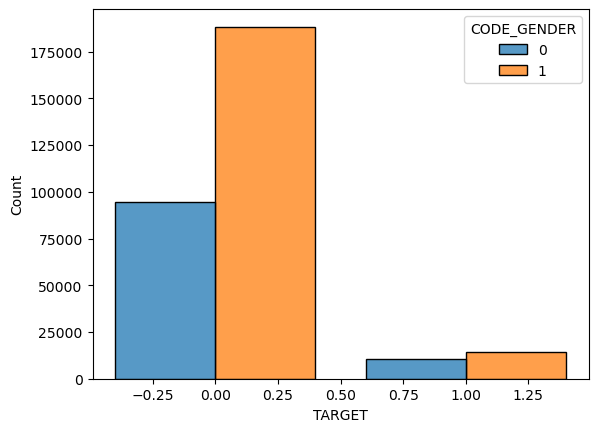

In [26]:
sns.histplot(data=df_train, x="TARGET", hue="CODE_GENDER", multiple="dodge", shrink=.8)

Text(0.5, 9.444444444444438, 'YEARS_BIRTH')

<Figure size 2500x500 with 0 Axes>

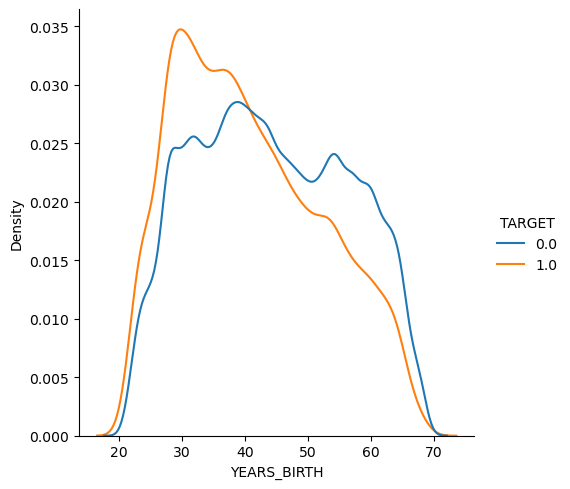

In [27]:
plt.figure(figsize=(25,5))
sns.displot(x=(-df_train['DAYS_BIRTH']/365),  data=df_train, hue = 'TARGET', common_norm=False, kind="kde")
plt.xlabel("YEARS_BIRTH")

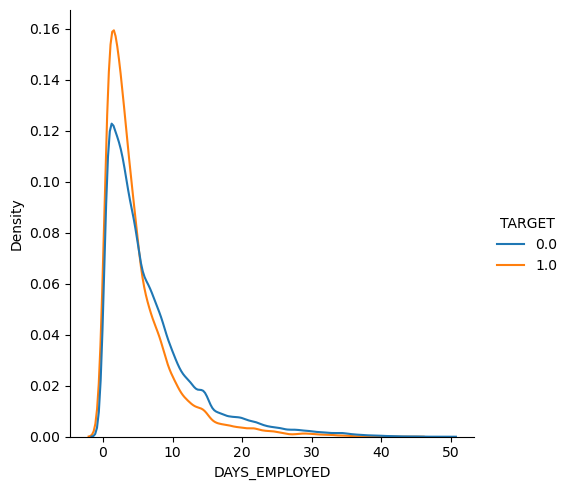

In [28]:
sns.displot(x=(-df['DAYS_EMPLOYED']/365),  data=df_train, hue = 'TARGET', common_norm=False, kind="kde")

<Figure size 2500x500 with 0 Axes>

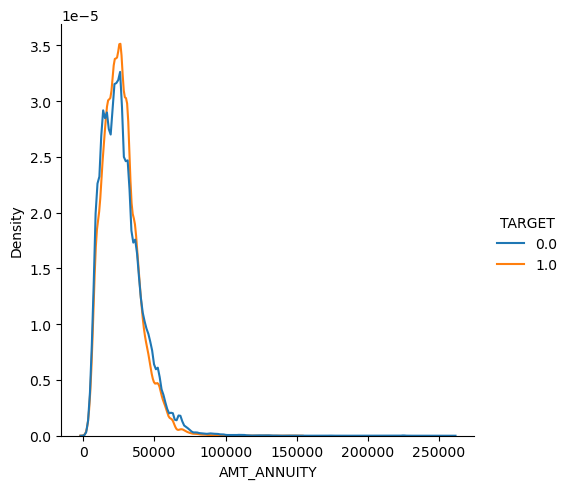

In [29]:
plt.figure(figsize=(25,5))
sns.displot(x='AMT_ANNUITY',  data=df_train, hue = 'TARGET', kind="kde", common_norm=False)

<Figure size 2500x500 with 0 Axes>

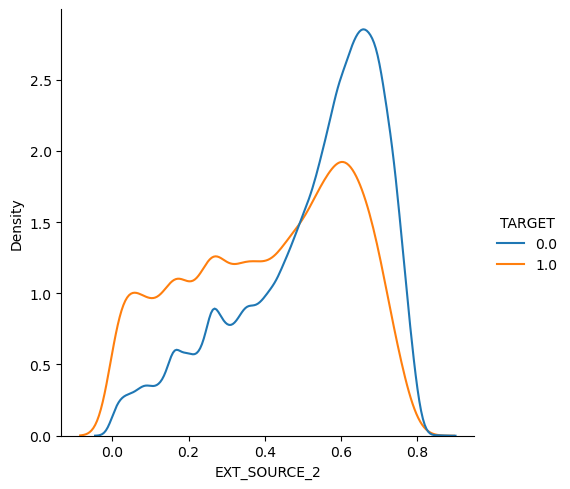

In [30]:
plt.figure(figsize=(25,5))
sns.displot(x='EXT_SOURCE_2',  data=df_train, hue = 'TARGET', kind="kde", common_norm=False)

<Figure size 2500x500 with 0 Axes>

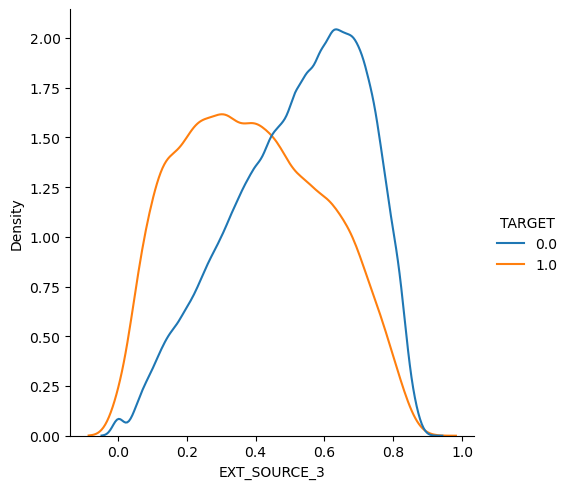

In [31]:
plt.figure(figsize=(25,5))
sns.displot(x='EXT_SOURCE_3',  data=df_train, hue = 'TARGET', kind="kde", common_norm=False)

### Préparation des datasets pour les traitements machine learning

In [32]:
df_train = df.loc[df['TARGET'].isna() == False]
df_pred = df.loc[df['TARGET'].isna()]

df_train.drop(columns = ['SK_ID_CURR'], inplace= True)

In [33]:
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

def preprocessing(df) : 
  limitPer = len(df) * .80
  df.dropna(thresh=limitPer, axis=1, inplace=True)
  df.dropna(inplace=True)
  print(df.shape)
  numeric_cols = df.select_dtypes(include=['float64','int64']).columns
  mms = MinMaxScaler()
  mms = mms.fit(df[numeric_cols])
  df[numeric_cols] = mms.transform(df[numeric_cols])
  df[numeric_cols]=df[numeric_cols][df[numeric_cols].apply(zscore) < 4]
  df.dropna(inplace=True)
  df.reset_index(drop=True, inplace=True)
  return df, mms

In [34]:
df_train, mms = preprocessing(df_train)

(201088, 201)


In [36]:
df_train.shape

(180800, 201)

In [37]:
df_pred.shape

(48744, 202)

In [38]:
df_train.head()

TARGET CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0    0.0           0            1               0      0.000000   
1    0.0           0            0               0      0.000000   
2    0.0           1            1               0      0.052632   
3    0.0           0            1               0      0.000000   
4    0.0           1            0               0      0.052632   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          0.000350    0.022472     0.018630         0.023569   
1          0.000619    0.111235     0.099738         0.103255   
2          0.001235    0.378458     0.153570         0.337823   
3          0.002851    0.370787     0.156593         0.371493   
4          0.000735    0.151685     0.074975         0.152637   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.134897    0.351176       0.987439           0.814201   
1                    0.491595    0.471297       0.911344           0.783234   
2                    0.491595    0.651792       0.825257           0.947095   
3                    0.039215    0.362360       0.974933           0.799503   
4                    0.311695    0.856140       0.962092           0.806917   

   DAYS_ID_PUBLISH FLAG_MOBIL FLAG_EMP_PHONE FLAG_WORK_PHONE FLAG_CONT_MOBILE  \
0         0.648326          1              1               1                1   
1         0.933722          1              1               1                1   
2         0.913992          1              1               0                1   
3         0.669446          1              1               1                1   
4         0.897457          1              1               0                1   

  FLAG_PHONE FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0          1          0         0.000000                   0.5   
1          1          0         0.052632                   0.5   
2          1          0         0.105263                   0.5   
3          0          0         0.052632                   1.0   
4          0          0         0.105263                   0.5   

   REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                          0.5                 0.391304   
1                          0.5                 0.695652   
2                          0.5                 0.695652   
3                          1.0                 0.695652   
4                          0.5                 0.652174   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                         0.0                         0.0   
1                         0.0                         0.0   
2                         0.0                         0.0   
3                         0.0                         0.0   
4                         0.0                         0.0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                          0.0                     0.0   
1                          0.0                     0.0   
2                          0.0                     0.0   
3                          0.0                     0.0   
4                          0.0                     0.0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_2  \
0                     0.0                      0.0      0.650189   
1                     0.0                      0.0      0.414297   
2                     0.0                      0.0      0.846784   
3                     1.0                      1.0      0.835414   
4                     0.0                      0.0      0.762412   

   EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
0      0.815983                  0.000000                       0.0   
1      0.694723                  0.000000                       0.0   
2      0.550152                  0.002874                       0.0   
3      0.604542                  0.005747                       0.0   
4      0.40675

In [39]:
df_train.dtypes

TARGET                 category
CODE_GENDER            category
FLAG_OWN_CAR           category
FLAG_OWN_REALTY        category
CNT_CHILDREN            float64
                         ...   
DAYS_EMPLOYED_PERC      float64
INCOME_CREDIT_PERC      float64
INCOME_PER_PERSON       float64
ANNUITY_INCOME_PERC     float64
PAYMENT_RATE            float64
Length: 201, dtype: object

### Fonction coût métier - création d'un score métier

Plusieurs mesures sont à notre disposition pour évaluer l'efficacité de nos modèles. 
Toutefois, en raison de la spécificité de notre problème, nous ne pouvons pas simplement utiliser l'accuracy ou la précision. En effet, d'une part, nous avons un jeu de données déséquilibré et, d'autre part, une personne qui ne rembourse pas son prêt (faux négatif) coûte environ dix fois plus cher à la banque qu'une personne qui aurait pu obtenir un prêt mais que nous avons refusé (faux positif).

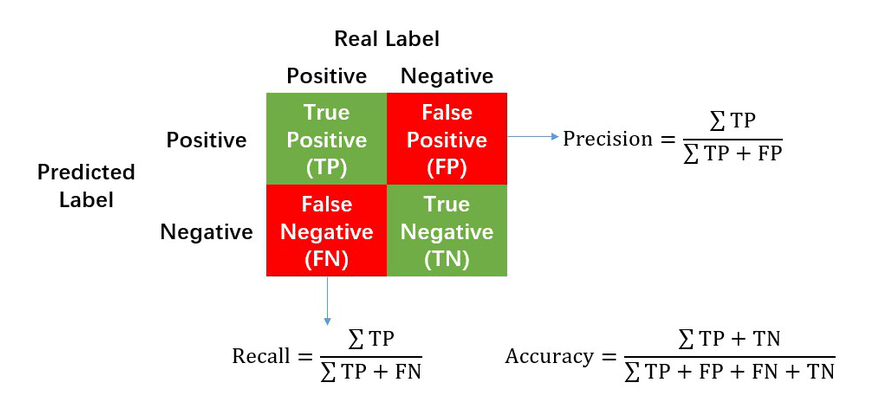

Pour tenir compte de cette particularité métier, nous allons utiliser la fonction F1 beta, dont la formule est présentée ci-dessous. Nous avons choisi d'utiliser cette solution avec un bêta de 3, car nous souhaitons que les faux négatifs aient environ 10 fois plus de poids que les faux positifs (β²=10 ⇔  β≃3)

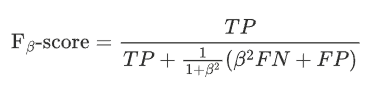

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV


fb = make_scorer(fbeta_score, beta=3) 

### DummyClassifier

Nous avons choisi de créer une baseline à partir du DummyClassifier afin de mesurer l'efficacité de nos modèles. Bien que nos données ne soient pas équilibrées, nous obtenons une accuracy de 0,92. En revanche, notre score F-beta est seulement de 0, ce qui nous montre la nécessité d'améliorer nos modèles pour mieux tenir compte de la spécificité métier.

Accuracy model score DummyClassifier()  : 0.9172345132743362
Accuracy model score DummyClassifier()  : 0.0


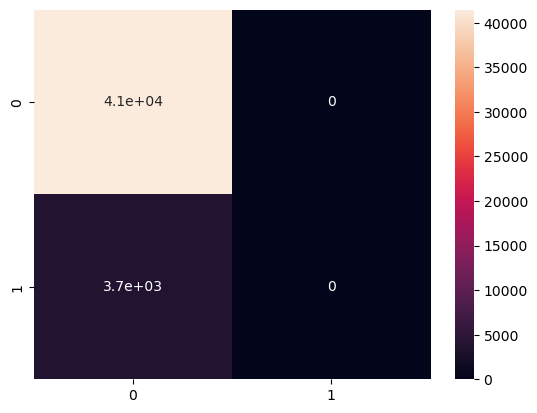

In [41]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


X_train, X_test, y_train, y_test = train_test_split(df_train.loc[:, df_train.columns != 'TARGET'], df_train[['TARGET']], stratify=df_train[['TARGET']])

model_baseline =  DummyClassifier()
model_baseline.fit(X_train,y_train)
y_predict = model_baseline.predict(X_test)

print("Accuracy model score {0}  : {1}".format(model_baseline,metrics.accuracy_score(y_test, y_predict)))
print("Accuracy model score {0}  : {1}".format(model_baseline,metrics.fbeta_score(y_test, y_predict, beta = 3)))
plt.figure()
cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True)
plt.show()


### Premiers tests modèles ML

Accuracy model score LogisticRegression(class_weight='balanced')  : 0.5239036115128429


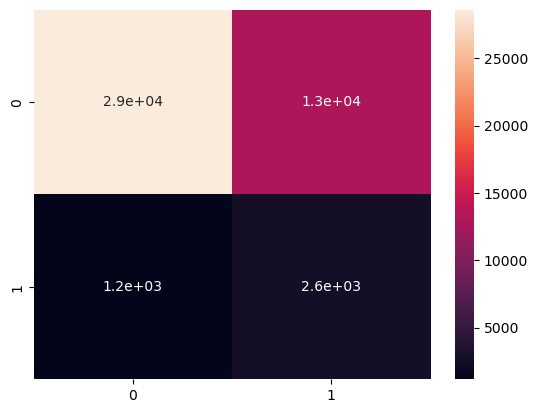

Accuracy model score GaussianNB()  : 0.47867607018103087


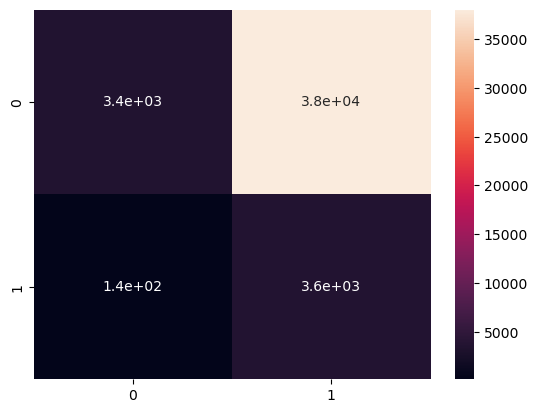

In [42]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



X_train, X_test, y_train, y_test = train_test_split(df_train.loc[:, df_train.columns != 'TARGET'], df_train[['TARGET']], stratify=df_train[['TARGET']])

models=[LogisticRegression(class_weight ='balanced'), GaussianNB()]

for model in models :
  model.fit(X_train,np.array(y_train))
  y_predict = model.predict(X_test)
  print("Accuracy model score {0}  : {1}".format(model,metrics.fbeta_score(y_test, y_predict, beta = 3)))
  plt.figure()
  cm = confusion_matrix(y_test, y_predict)
  sns.heatmap(cm, annot=True)
  plt.show()

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Accuracy model score LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
               min_child_weight=39.3259775, min_split_gain=0.0222415,
               n_estimators=10000, nthread=4, num_leaves=34,
               reg_alpha=0.041545473, reg_lambda=0.0735294, silent=-1,
               subsample=0.8715623, verbose=-1)  : 0.06146281499692686


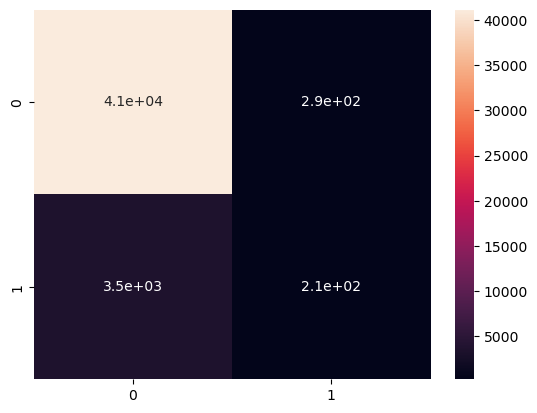

In [43]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier( nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1)

clf.fit(X_train,y_train, eval_metric= 'auc')
y_predict = clf.predict(X_test)
print("Accuracy model score {0}  : {1}".format(clf,metrics.fbeta_score(y_test, y_predict, beta = 3)))
plt.figure()
cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True)
plt.show()

In [44]:
### Fonction plot ROC_AUC

def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Actual values')
    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [45]:
### Over-sampling

from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 



X_train, X_test, y_train, y_test = train_test_split(df_train.loc[:, df_train.columns != 'TARGET'], df_train[['TARGET']], stratify=df_train[['TARGET']])

X = pd.concat([X_train, y_train], axis=1)
class_count_0, class_count_1 = X['TARGET'].value_counts()
class_0 = X[X['TARGET'] == 0]
class_1 = X[X['TARGET'] == 1]

class_1_over = class_1.sample(class_count_0, replace=True)
X = pd.concat([class_1_over, class_0], axis=0)

X_train, y_train = X.loc[:, X.columns != 'TARGET'], X[['TARGET']]

<Figure size 640x480 with 0 Axes>

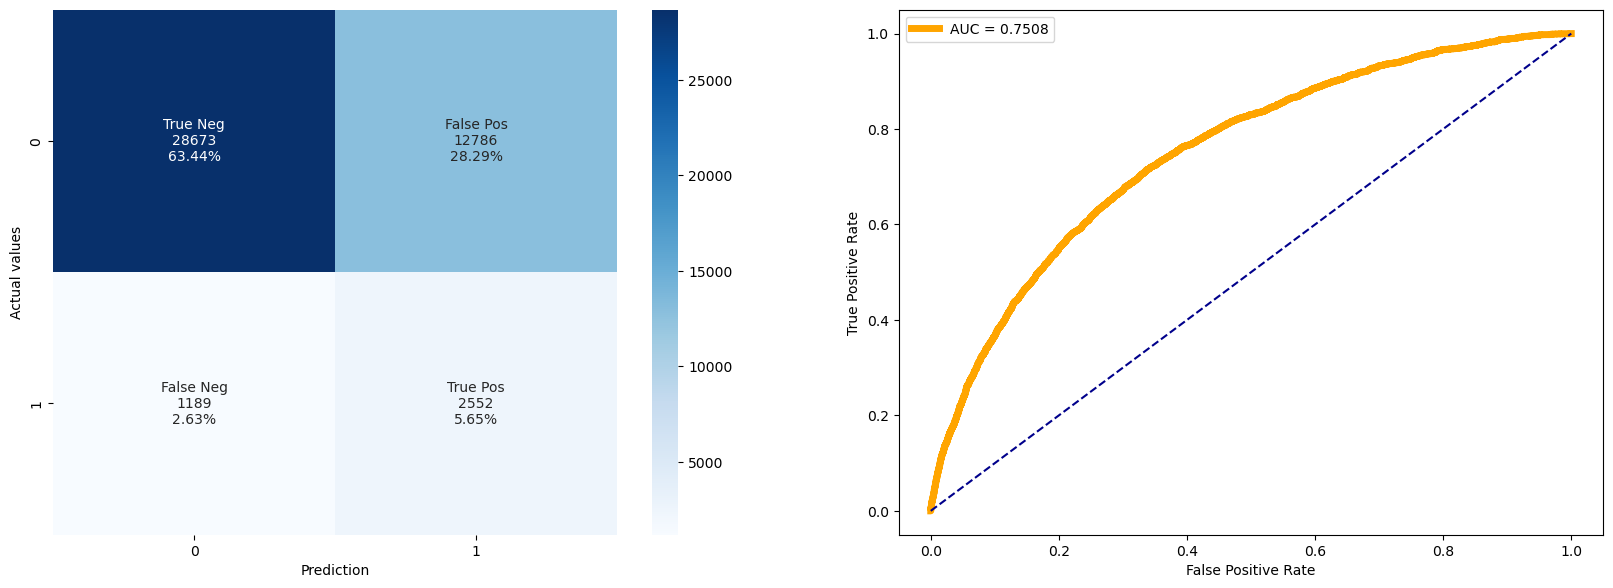

F1 betascore model LogisticRegression() : 0.5207419348256371


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

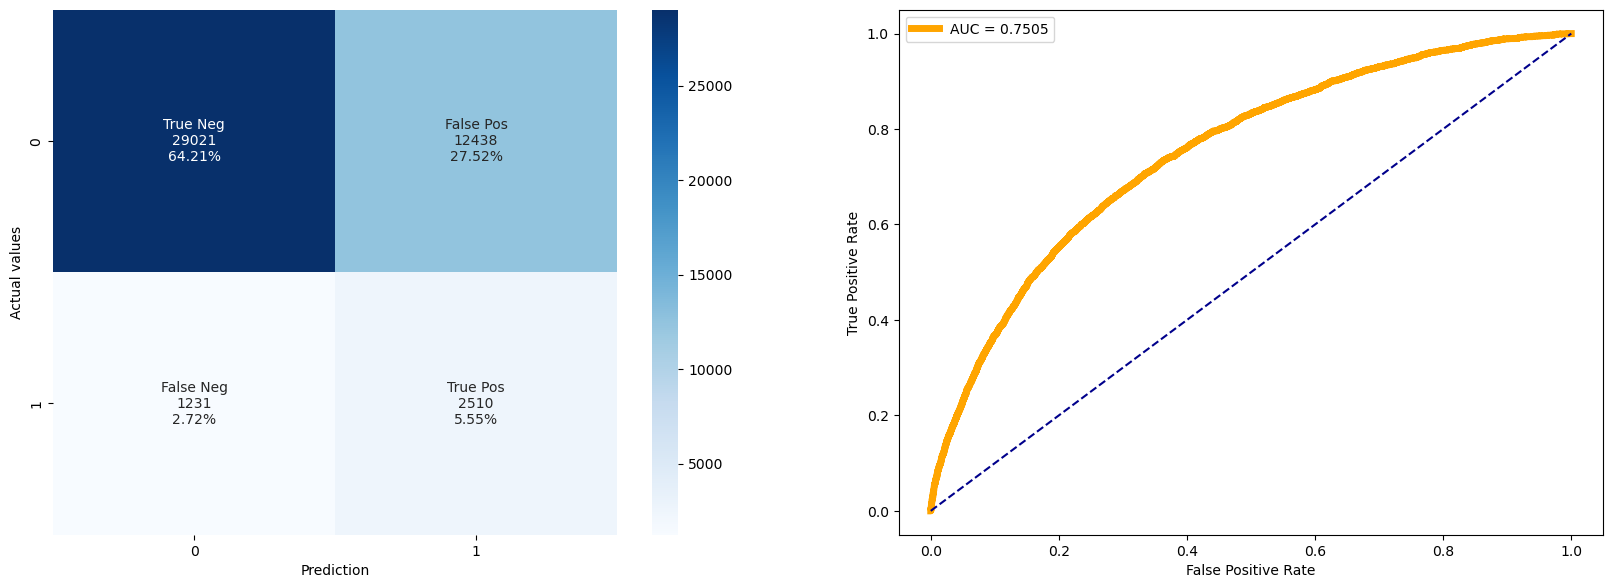

F1 betascore model AdaBoostClassifier() : 0.5162803134705967


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

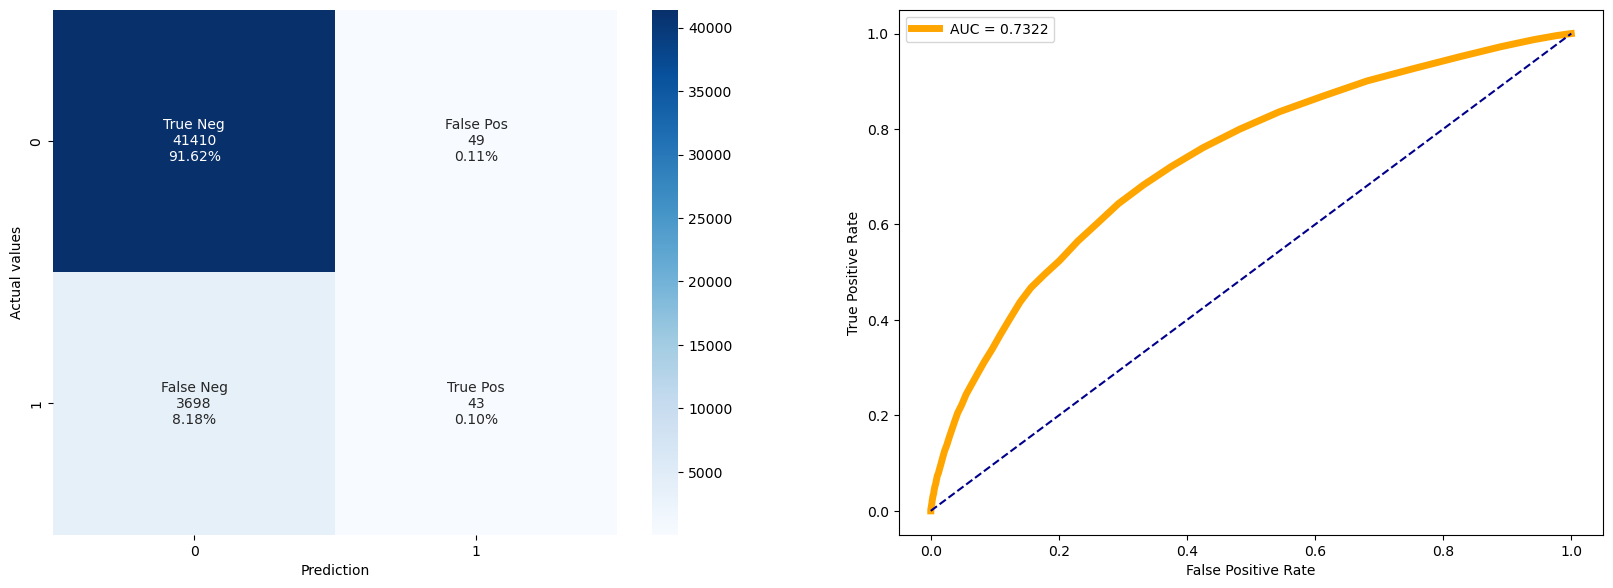

F1 betascore model RandomForestClassifier() : 0.012736589555996566


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

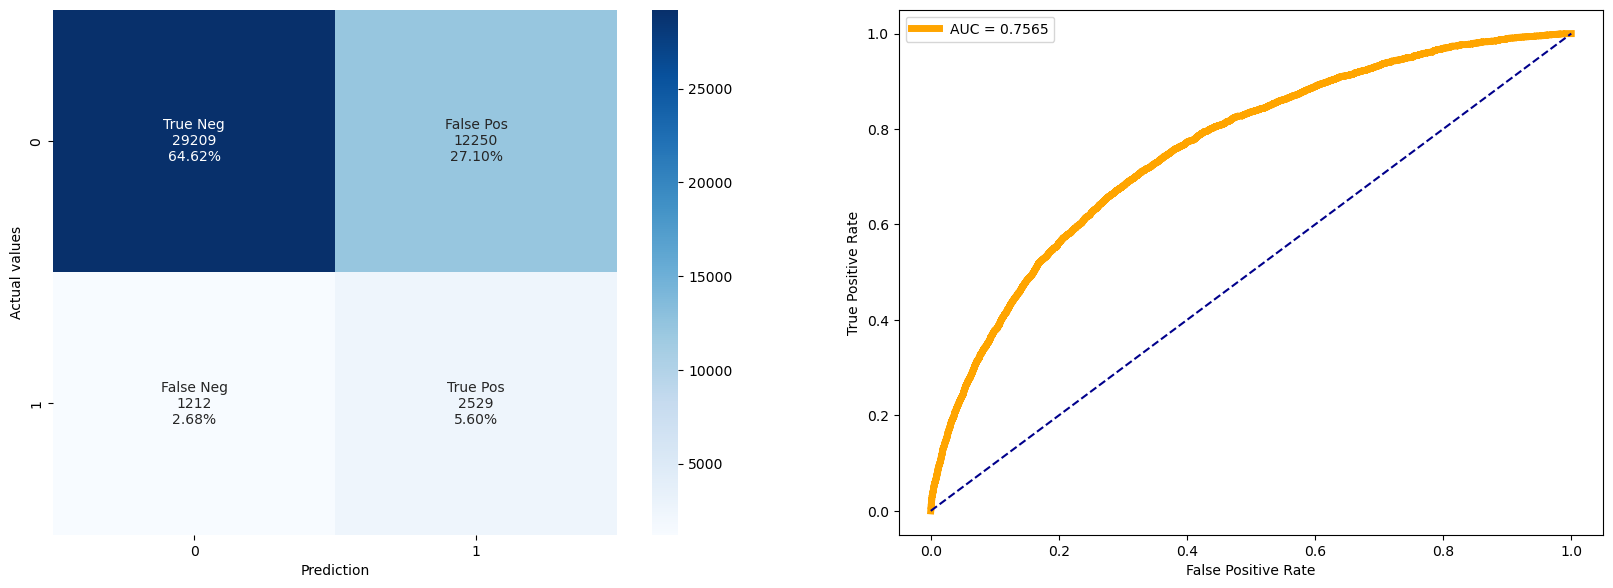

F1 betascore model GradientBoostingClassifier() : 0.5220029722589168


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

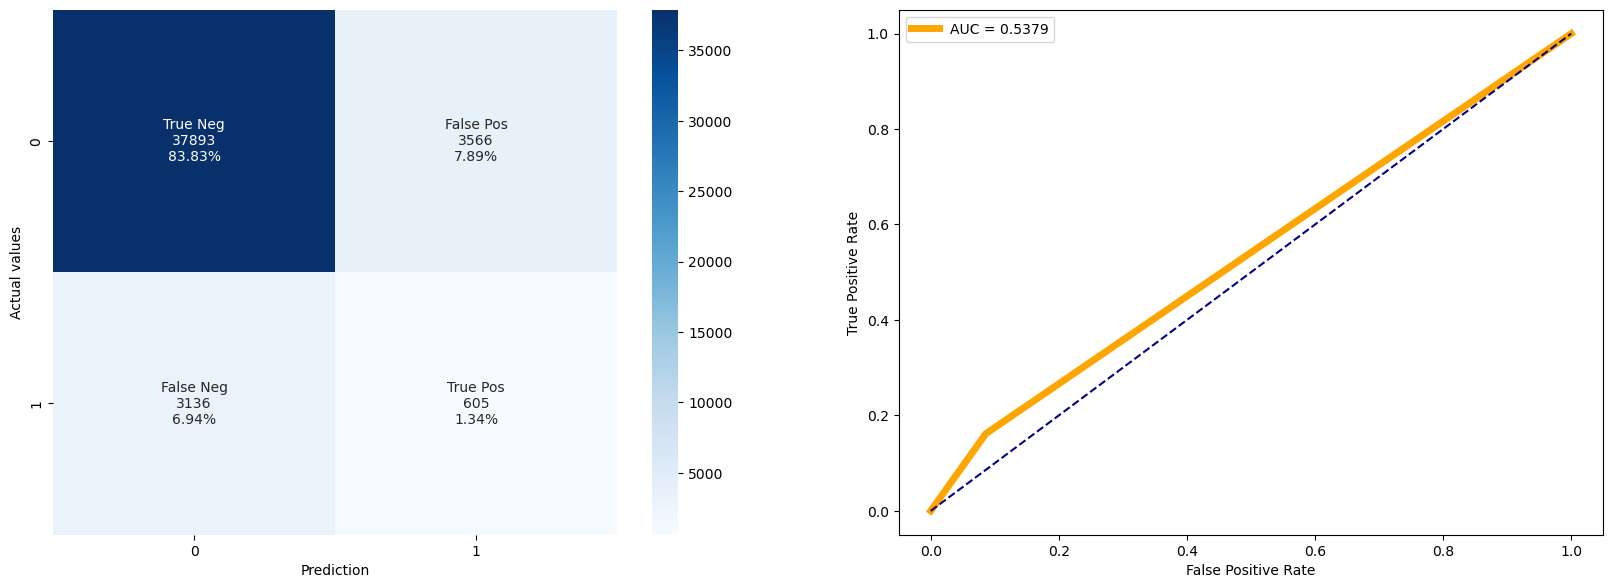

F1 betascore model DecisionTreeClassifier() : 0.15988372093023254


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

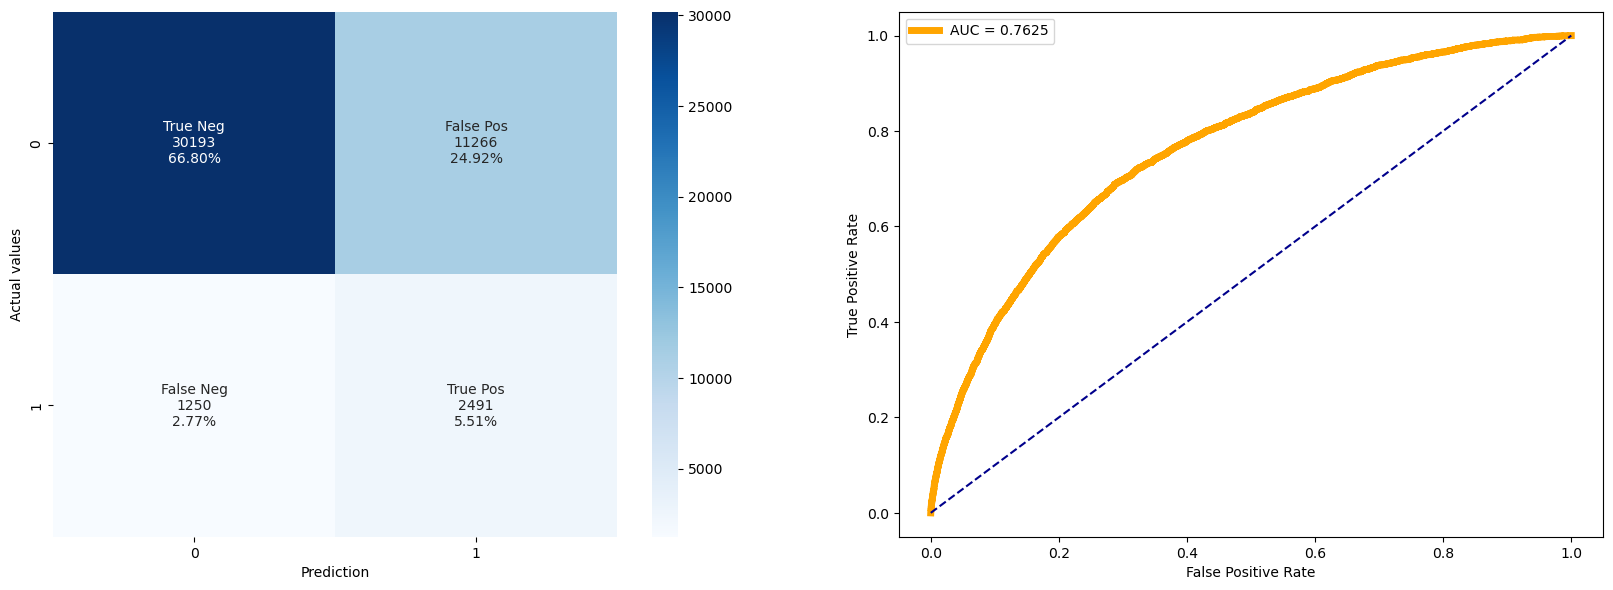

F1 betascore model LGBMClassifier() : 0.5252393202041075


<Figure size 640x480 with 0 Axes>

In [46]:
import mlflow
from sklearn.metrics import roc_auc_score

# Définir l'URI de suivi MLflow
# mlflow server
mlflow.set_tracking_uri('http://127.0.0.1:5000')  


models = [LogisticRegression(), AdaBoostClassifier(), RandomForestClassifier(),
          GradientBoostingClassifier(), DecisionTreeClassifier(), LGBMClassifier()]

for model in models:
    mlflow.start_run()
    mlflow.log_param("model_name", str(model))

    model.fit(X_train, y_train.values.ravel())
    y_predict = model.predict(X_test)
    f1_score = metrics.fbeta_score(y_test, y_predict, beta=3)
    mlflow.log_metric("F1_score", f1_score)

    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    mlflow.log_metric("ROC_AUC", roc_auc)

    plt.figure()
    cf_matrix_roc_auc(model, y_test, model.predict(X_test), model.predict_proba(X_test)[:, 1])
    plt.savefig("cf_matrix.png")
    mlflow.log_artifact("cf_matrix.png")

    mlflow.end_run()

    print("F1 betascore model {0} : {1}".format(model, metrics.fbeta_score(y_test, y_predict, beta=3)))

### SMOTE

0.0    10344
1.0      906
Name: TARGET, dtype: int64
Avant transformation avec SMOTENC : 10344 906
(20688, 200) (11250, 200)
Après transformation avec SMOTENC : 10344 10344
Accuracy model score LGBMClassifier()  : 0.07734806629834254


<Figure size 640x480 with 0 Axes>

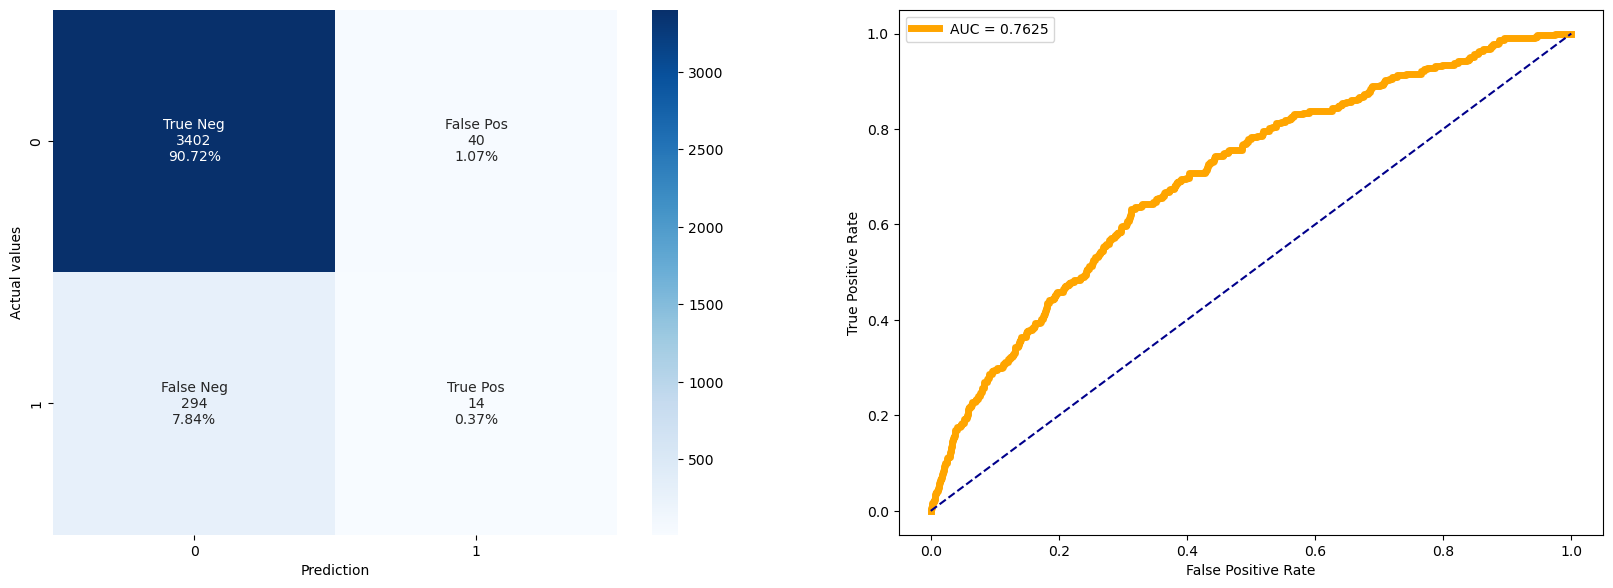

In [47]:
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTENC


X_train, X_test, y_train, y_test = train_test_split(df_train.loc[:, df_train.columns != 'TARGET'].head(15000), df_train[['TARGET']].head(15000))

print(y_train['TARGET'].value_counts())
class_count_0, class_count_1 = y_train['TARGET'].value_counts()
print('Avant transformation avec SMOTENC :', class_count_0,class_count_1) 

smote = SMOTENC(categorical_features= np.array(df_train.dtypes == 'category'))

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X_train, y_train)

print(x_smote.shape,X_train.shape)


X_train, y_train = x_smote, y_smote

class_count_0, class_count_1 = y_train['TARGET'].value_counts()
print('Après transformation avec SMOTENC :', class_count_0,class_count_1) 

models=[LGBMClassifier()]

for model in models :
  model.fit(X_train,np.array(y_train))
  y_predict = model.predict(X_test)
  print("Accuracy model score {0}  : {1}".format(model,metrics.f1_score(y_test, y_predict)))
  plt.figure()
  cf_matrix_roc_auc(model, y_test, model.predict(X_test), model.predict_proba(X_test)[:,1])

### Under-sampling

In [48]:
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import RFE
from lightgbm import LGBMClassifier


X_train, X_test, y_train, y_test = train_test_split(df_train.loc[:, df_train.columns != 'TARGET'], df_train[['TARGET']])

X = pd.concat([X_train, y_train], axis=1)
class_count_0, class_count_1 = X['TARGET'].value_counts()
class_0 = X[X['TARGET'] == 0]
class_1 = X[X['TARGET'] == 1]

class_0_under = class_0.sample(class_count_1)
X = pd.concat([class_1, class_0_under], axis=0)
print('under_sampling :', X['TARGET'].value_counts()) 

X_train, y_train = X.loc[:, X.columns != 'TARGET'], X[['TARGET']]

under_sampling : 0.0    11262
1.0    11262
Name: TARGET, dtype: int64


### Tests différents modèles

In [49]:
import mlflow
from sklearn.metrics import fbeta_score

models = [LogisticRegression(), AdaBoostClassifier(), RandomForestClassifier(),
          GradientBoostingClassifier(), DecisionTreeClassifier(), LGBMClassifier()]

# Spécifiez l'URL de suivi MLflow correspondant à votre serveur MLflow
mlflow.set_tracking_uri('http://127.0.0.1:5000')

for model in models:
    # Commencez un nouvel enregistrement
    mlflow.start_run()

    # Enregistrez le nom du modèle comme paramètre
    mlflow.log_param("model_name", str(model))

    # Entraînez le modèle
    model.fit(X_train, np.array(y_train))

    # Faites des prédictions sur les données de test
    y_predict = model.predict(X_test)
    
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    mlflow.log_metric("ROC_AUC", roc_auc)

    # Calculez et enregistrez le score F1 beta
    f1_score = fbeta_score(y_test, y_predict, beta=3)
    mlflow.log_metric("F1_score", f1_score)

    # Terminez l'enregistrement
    mlflow.end_run()

    # Affichez le score F1 beta
    print("F1 betascore model {0}: {1}".format(model, f1_score))


F1 betascore model LogisticRegression(): 0.51886404734506
F1 betascore model AdaBoostClassifier(): 0.5107304993809327
F1 betascore model RandomForestClassifier(): 0.5068218049315749
F1 betascore model GradientBoostingClassifier(): 0.517569243489045
F1 betascore model DecisionTreeClassifier(): 0.4114788946249621
F1 betascore model LGBMClassifier(): 0.5257390944800496


In [51]:
runs = mlflow.search_runs()

In [52]:
# Extraire les métriques des résultats
metrics = runs[['run_id', 'params.model_name', 'metrics.F1_score', 'metrics.ROC_AUC']]

# Enregistrer les métriques dans un fichier CSV
metrics.to_csv('metrics.csv', index=False)

In [53]:
metrics

run_id             params.model_name  \
0   77b17a16f2274c019fc9fb9dee95f0e6              LGBMClassifier()   
1   e0e5d2e3d52c4d36a74d333997e99f37      DecisionTreeClassifier()   
2   e4cde45751444dbcaf590f66b13341e4  GradientBoostingClassifier()   
3   a68e047dff83405b97baac564ae4c123      RandomForestClassifier()   
4   47082fd919c3449780c81228f240769a          AdaBoostClassifier()   
5   ffb52387ef7d4247abc9eb7b69261d34          LogisticRegression()   
6   3602740b327f472489f9651f6b336a6c              LGBMClassifier()   
7   6b3df8d5cbea4e46928649bb2873cc94      DecisionTreeClassifier()   
8   0dc21b941d654058b4455acda353b85c  GradientBoostingClassifier()   
9   f76e5c12b5004f1ea79befa5c2b3f90e      RandomForestClassifier()   
10  428f9d4b6e2d49bca84151239bdbdbb0          AdaBoostClassifier()   
11  db770ea43d764c1da9ce4ba9636d38a5          LogisticRegression()   

    metrics.F1_score  metrics.ROC_AUC  
0           0.525739         0.757090  
1           0.411479         0.585527  
2           0.517569         0.755180  
3           0.506822         0.743317  
4           0.510730         0.747377  
5           0.518864         0.749895  
6           0.525239         0.762531  
7           0.159884         0.537854  
8           0.522003         0.756470  
9           0.012737         0.732182  
10          0.516280         0.750514  
11          0.520742         0.750832

### Under-sampling GS LGBMClassifier

under_sampling : 0.0    11315
1.0    11315
Name: TARGET, dtype: int64
(22630, 62)
Optimal number of features: 62
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [

[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
0.5161168945190017


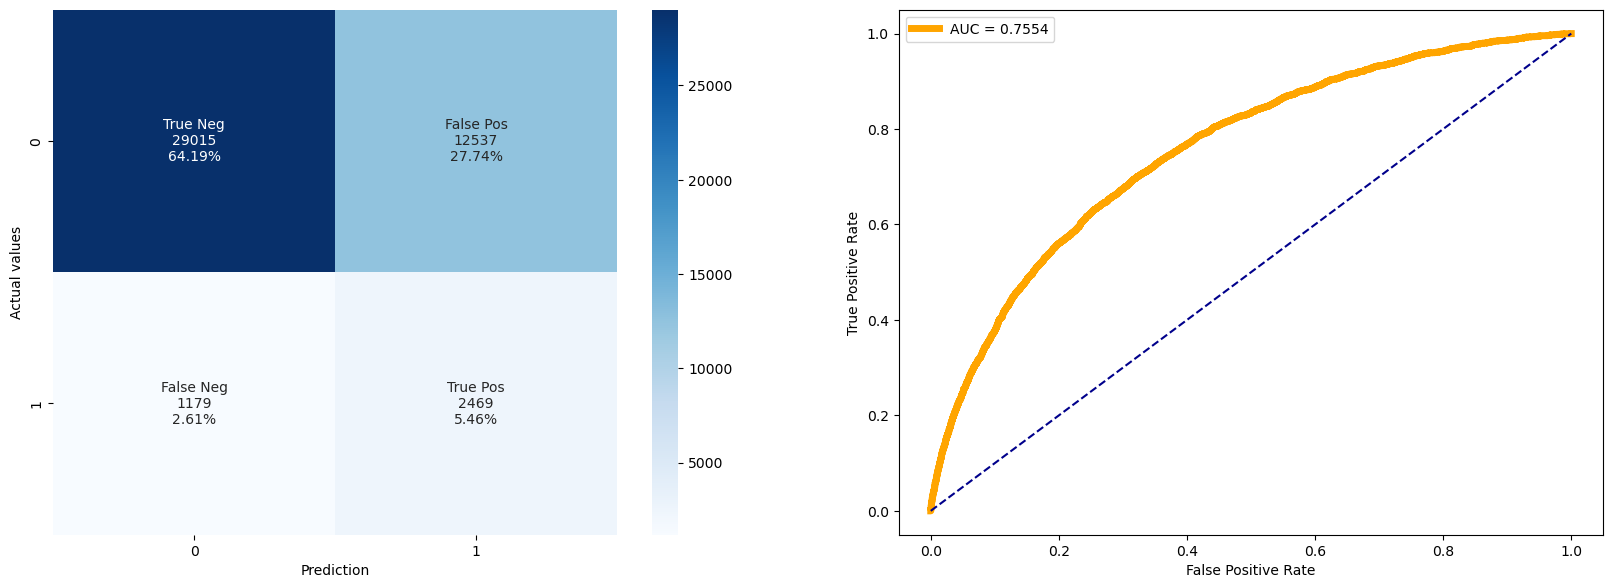

{'cv': 3, 'estimator__boosting_type': 'gbdt', 'estimator__class_weight': None, 'estimator__colsample_bytree': 1.0, 'estimator__importance_type': 'split', 'estimator__learning_rate': 0.1, 'estimator__max_depth': -1, 'estimator__min_child_samples': 20, 'estimator__min_child_weight': 0.001, 'estimator__min_split_gain': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': -1, 'estimator__num_leaves': 31, 'estimator__objective': None, 'estimator__random_state': None, 'estimator__reg_alpha': 0.0, 'estimator__reg_lambda': 0.0, 'estimator__silent': 'warn', 'estimator__subsample': 1.0, 'estimator__subsample_for_bin': 200000, 'estimator__subsample_freq': 0, 'estimator': LGBMClassifier(), 'importance_getter': 'auto', 'min_features_to_select': 1, 'n_jobs': None, 'scoring': make_scorer(fbeta_score, beta=3), 'step': 1, 'verbose': 0}


In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
import warnings
from sklearn import metrics
warnings.simplefilter(action='ignore', category=FutureWarning)


X_train, X_test, y_train, y_test = train_test_split(df_train.loc[:, df_train.columns != 'TARGET'], df_train[['TARGET']])

X = pd.concat([X_train, y_train], axis=1)
class_count_0, class_count_1 = X['TARGET'].value_counts()
class_0 = X[X['TARGET'] == 0]
class_1 = X[X['TARGET'] == 1]

class_0_under = class_0.sample(class_count_1)
X = pd.concat([class_1, class_0_under], axis=0)
print('under_sampling :', X['TARGET'].value_counts()) 

X_train, y_train = X.loc[:, X.columns != 'TARGET'], X[['TARGET']]

parameters = {"min_data_in_leaf" : np.arange(20,120,10), "learning_rate" :  np.arange(0.01,0.10,0.01)}

model = LGBMClassifier()
selector = RFECV(model, step=1, cv=3, scoring=fb)
selector = selector.fit(X_train, y_train.values.ravel())
print(selector.transform(X_train).shape)
print('Optimal number of features: {}'.format(selector.n_features_))
clf = GridSearchCV(model, parameters, cv=3, scoring=fb)
clf.fit(selector.transform(X_train), y_train.values.ravel())
GSmodel = clf.best_estimator_
y_predict = GSmodel.predict(selector.transform(X_test))
print(metrics.fbeta_score(y_test, y_predict, beta = 3))
roc_auc = roc_auc_score(y_test, GSmodel.predict_proba(selector.transform(X_test))[:,1])
cf_matrix_roc_auc(GSmodel, y_test,  y_predict, GSmodel.predict_proba(selector.transform(X_test))[:,1])
print(selector.get_params())

In [58]:
clf.best_estimator_

LGBMClassifier(learning_rate=0.06999999999999999, min_data_in_leaf=50)

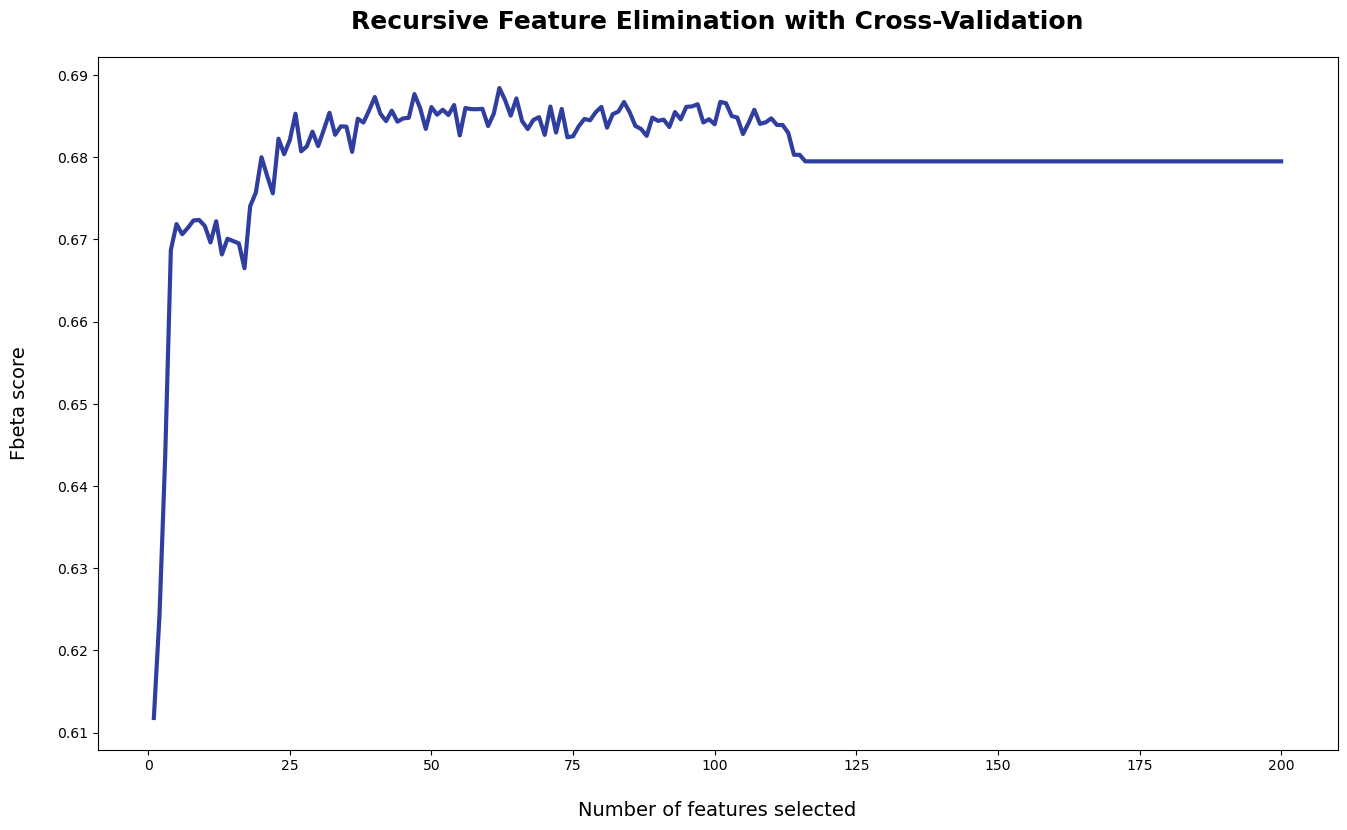

In [59]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('Fbeta score', fontsize=14, labelpad=20)
plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1), selector.cv_results_['mean_test_score'], color='#303F9F', linewidth=3)
plt.show()


[ 13  14  16  18  23  24  25  27  28  34  36  38  39  40  41  42  43  44
  46  47  48  49  50  51  53  54  55  56  57  58  63  64  65  66  67  68
  69  70  71  72  73  74  76  77  79  81  84  86  87  88  89  90  93  94
  95  96  97  98 101 103 105 106 107 108 109 110 111 112 113 114 115 117
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144 145 146 148 150 151 152 153 154 155 156 157 158
 159 160 161 162 164 165 166 167 168 169 170 171 172 173 174 176 177 178
 179 182 184 185 186 187 188 189 191 192 193 194]


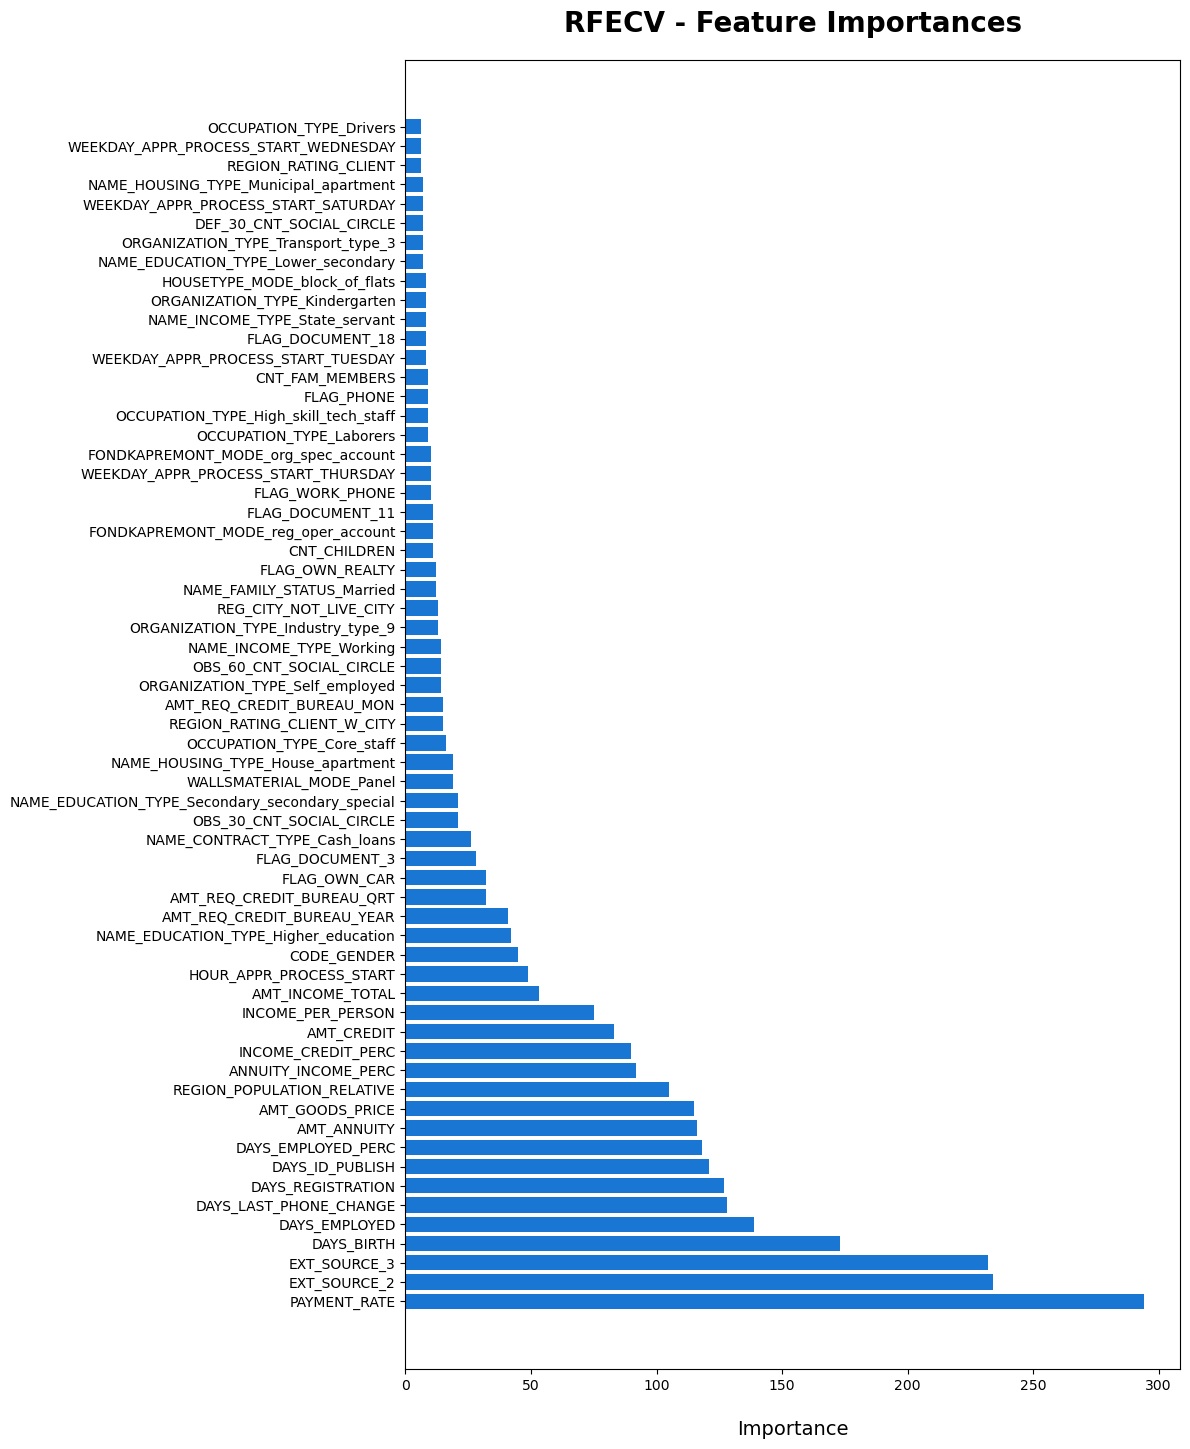

In [60]:
print(np.where(selector.support_ == False)[0])

X_train.drop(X_train.columns[np.where(selector.support_ == False)[0]], axis=1, inplace=True)

dset = pd.DataFrame()
dset['Feature'] = X_train.columns
dset['Importance'] = selector.estimator_.feature_importances_

dset = dset.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 17))
plt.barh(y=dset['Feature'], width=dset['Importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [61]:
dset['Feature'][:30].values

array(['PAYMENT_RATE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 'DAYS_EMPLOYED_PERC', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'ANNUITY_INCOME_PERC', 'INCOME_CREDIT_PERC', 'AMT_CREDIT',
       'INCOME_PER_PERSON', 'AMT_INCOME_TOTAL', 'HOUR_APPR_PROCESS_START',
       'CODE_GENDER', 'NAME_EDUCATION_TYPE_Higher_education',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'FLAG_OWN_CAR', 'FLAG_DOCUMENT_3', 'NAME_CONTRACT_TYPE_Cash_loans',
       'OBS_30_CNT_SOCIAL_CIRCLE',
       'NAME_EDUCATION_TYPE_Secondary_secondary_special',
       'WALLSMATERIAL_MODE_Panel', 'NAME_HOUSING_TYPE_House_apartment',
       'OCCUPATION_TYPE_Core_staff'], dtype=object)

In [62]:
dset['Importance'][:30].sum()/dset['Importance'].sum()

0.8953333333333333

Nous allons relancer le modèle en gardant que les 30 features les plus importantes :

In [63]:
df.head(2)

SK_ID_CURR TARGET CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0      100002    1.0           0            0               0             0   
1      100003    0.0           1            0               1             0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          202500.0    406597.5      24700.5         351000.0   
1          270000.0   1293502.5      35698.5        1129500.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461         -637.0            -3648.0   
1                    0.003541      -16765        -1188.0            -1186.0   

   DAYS_ID_PUBLISH FLAG_MOBIL FLAG_EMP_PHONE FLAG_WORK_PHONE FLAG_CONT_MOBILE  \
0            -2120          1              1               0                1   
1             -291          1              1               0                1   

  FLAG_PHONE FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0          1          0              1.0                     2   
1          1          0              2.0                     1   

   REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                            2                       10   
1                            1                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_2  \
0                       0                        0      0.262949   
1                       0                        0      0.622246   

   EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
0      0.139376                       2.0                       2.0   
1           NaN                       1.0                       0.0   

   OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  DAYS_LAST_PHONE_CHANGE  \
0                       2.0                       2.0                 -1134.0   
1                       1.0                       0.0                  -828.0   

  FLAG_DOCUMENT_2 FLAG_DOCUMENT_3 FLAG_DOCUMENT_4 FLAG_DOCUMENT_5  \
0               0               1               0               0   
1               0               1               0               0   

  FLAG_DOCUMENT_6 FLAG_DOCUMENT_7 FLAG_DOCUMENT_8 FLAG_DOCUMENT_9  \
0               0               0               0               0   
1               0               0               0               0   

  FLAG_DOCUMENT_10 FLAG_DOCUMENT_11 FLAG_DOCUMENT_12 FLAG_DOCUMENT_13  \
0                0                0                0                0   
1                0                0                0                0   

  FLAG_DOCUMENT_14 FLAG_DOCUMENT_15 FLAG_DOCUMENT_16 FLAG_DOCUMENT_17  \
0                0                0                0                0   
1                0                0                0                0   

  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0                0                0                0                0   
1                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   

  AMT_REQ_CREDIT_BUREAU_WEEK AMT_REQ_CREDIT_BUREAU_MON  \
0                        0.0                       0.0   
1                        0.0                       0.0   

  AMT_REQ_CREDIT_BUREAU_QRT AMT_REQ_CREDIT_BUREAU_YEAR  \
0                       0.0                        1.0   
1                       0.0                        0.0   

  NAME_CONTRACT_TYPE_Cash_loans  ... ORGANIZATION_TYPE_Industry_type_1  \
0            

In [64]:
df.shape

(356251, 202)

In [65]:
df_red = df[['SK_ID_CURR','TARGET','PAYMENT_RATE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 'DAYS_EMPLOYED_PERC', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'ANNUITY_INCOME_PERC', 'INCOME_CREDIT_PERC', 'AMT_CREDIT',
       'INCOME_PER_PERSON', 'AMT_INCOME_TOTAL', 'HOUR_APPR_PROCESS_START',
       'CODE_GENDER', 'NAME_EDUCATION_TYPE_Higher_education',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'FLAG_OWN_CAR', 'FLAG_DOCUMENT_3', 'NAME_CONTRACT_TYPE_Cash_loans',
       'OBS_30_CNT_SOCIAL_CIRCLE',
       'NAME_EDUCATION_TYPE_Secondary_secondary_special',
       'WALLSMATERIAL_MODE_Panel', 'NAME_HOUSING_TYPE_House_apartment',
       'OCCUPATION_TYPE_Core_staff']]

In [66]:
df_red.head(2)

SK_ID_CURR TARGET  PAYMENT_RATE  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH  \
0      100002    1.0      0.060749      0.262949      0.139376       -9461   
1      100003    0.0      0.027598      0.622246           NaN      -16765   

   DAYS_EMPLOYED  DAYS_LAST_PHONE_CHANGE  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
0         -637.0                 -1134.0            -3648.0            -2120   
1        -1188.0                  -828.0            -1186.0             -291   

   DAYS_EMPLOYED_PERC  AMT_ANNUITY  AMT_GOODS_PRICE  \
0            0.067329      24700.5         351000.0   
1            0.070862      35698.5        1129500.0   

   REGION_POPULATION_RELATIVE  ANNUITY_INCOME_PERC  INCOME_CREDIT_PERC  \
0                    0.018801             0.121978            0.498036   
1                    0.003541             0.132217            0.208736   

   AMT_CREDIT  INCOME_PER_PERSON  AMT_INCOME_TOTAL  HOUR_APPR_PROCESS_START  \
0    406597.5           202500.0          202500.0                       10   
1   1293502.5           135000.0          270000.0                       11   

  CODE_GENDER NAME_EDUCATION_TYPE_Higher_education AMT_REQ_CREDIT_BUREAU_YEAR  \
0           0                                    0                        1.0   
1           1                                    1                        0.0   

  AMT_REQ_CREDIT_BUREAU_QRT FLAG_OWN_CAR FLAG_DOCUMENT_3  \
0                       0.0            0               1   
1                       0.0            0               1   

  NAME_CONTRACT_TYPE_Cash_loans  OBS_30_CNT_SOCIAL_CIRCLE  \
0                             1                       2.0   
1                             1                       1.0   

  NAME_EDUCATION_TYPE_Secondary_secondary_special WALLSMATERIAL_MODE_Panel  \
0                                               1                        0   
1                                               0                        0   

  NAME_HOUSING_TYPE_House_apartment OCCUPATION_TYPE_Core_staff  
0                                 1                          0  
1                                 1                          1

In [67]:
df_red.shape

(356251, 32)

In [68]:
df_train = df_red.loc[df_red['TARGET'].isna() == False]
df_pred = df_red.loc[df_red['TARGET'].isna()]

df_train.drop(columns = ['SK_ID_CURR'], inplace= True)

In [69]:
df_train.shape

(307507, 31)

In [70]:
df_pred.shape

(48744, 32)

In [71]:
df_train, mms = preprocessing(df_train)

(201088, 31)


In [72]:
df_train.head(3)

TARGET  PAYMENT_RATE  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH  DAYS_EMPLOYED  \
0    1.0      0.361216      0.307541      0.155407    0.898140       0.964437   
1    0.0      0.253390      0.650189      0.815983    0.351176       0.987439   
2    0.0      0.314594      0.414297      0.694723    0.471297       0.911344   

   DAYS_LAST_PHONE_CHANGE  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
0                0.729032           0.840893         0.705433   
1                0.805257           0.814201         0.648326   
2                0.394026           0.783234         0.933722   

   DAYS_EMPLOYED_PERC  AMT_ANNUITY  AMT_GOODS_PRICE  \
0            0.092382     0.088736         0.077441   
1            0.016209     0.018630         0.023569   
2            0.128616     0.099738         0.103255   

   REGION_POPULATION_RELATIVE  ANNUITY_INCOME_PERC  INCOME_CREDIT_PERC  \
0                    0.256321             0.083890            0.002250   
1                    0.134897             0.068747            0.002260   
2                    0.491595             0.191361            0.000826   

   AMT_CREDIT  INCOME_PER_PERSON  AMT_INCOME_TOTAL  HOUR_APPR_PROCESS_START  \
0    0.090287           0.005106          0.001504                 0.434783   
1    0.022472           0.001644          0.000350                 0.391304   
2    0.111235           0.001183          0.000619                 0.695652   

  CODE_GENDER NAME_EDUCATION_TYPE_Higher_education AMT_REQ_CREDIT_BUREAU_YEAR  \
0           0                                    0                        1.0   
1           0                                    0                        0.0   
2           0                                    0                        1.0   

  AMT_REQ_CREDIT_BUREAU_QRT FLAG_OWN_CAR FLAG_DOCUMENT_3  \
0                       0.0            0               1   
1                       0.0            1               0   
2                       1.0            0               1   

  NAME_CONTRACT_TYPE_Cash_loans  OBS_30_CNT_SOCIAL_CIRCLE  \
0                             1                  0.005747   
1                             0                  0.000000   
2                             1                  0.000000   

  NAME_EDUCATION_TYPE_Secondary_secondary_special WALLSMATERIAL_MODE_Panel  \
0                                               1                        0   
1                                               1                        0   
2                                               1                        0   

  NAME_HOUSING_TYPE_House_apartment OCCUPATION_TYPE_Core_staff  
0                                 1                          0  
1                                 1                          0  
2                                 1                          0

In [73]:
df_train.shape

(197065, 31)

In [74]:
df_pred.head(3)

SK_ID_CURR TARGET  PAYMENT_RATE  EXT_SOURCE_2  EXT_SOURCE_3  \
307511      100001    NaN      0.036147      0.789654      0.159520   
307512      100005    NaN      0.077973      0.291656      0.432962   
307513      100013    NaN      0.105202      0.699787      0.610991   

        DAYS_BIRTH  DAYS_EMPLOYED  DAYS_LAST_PHONE_CHANGE  DAYS_REGISTRATION  \
307511      -19241        -2329.0                 -1740.0            -5170.0   
307512      -18064        -4469.0                     0.0            -9118.0   
307513      -20038        -4458.0                  -856.0            -2175.0   

        DAYS_ID_PUBLISH  DAYS_EMPLOYED_PERC  AMT_ANNUITY  AMT_GOODS_PRICE  \
307511             -812            0.121044      20560.5         450000.0   
307512            -1623            0.247398      17370.0         180000.0   
307513            -3503            0.222477      69777.0         630000.0   

        REGION_POPULATION_RELATIVE  ANNUITY_INCOME_PERC  INCOME_CREDIT_PERC  \
307511                    0.018850             0.152300            0.237342   
307512                    0.035792             0.175455            0.444409   
307513                    0.019101             0.344578            0.305308   

        AMT_CREDIT  INCOME_PER_PERSON  AMT_INCOME_TOTAL  \
307511    568800.0            67500.0          135000.0   
307512    222768.0            49500.0           99000.0   
307513    663264.0           101250.0          202500.0   

        HOUR_APPR_PROCESS_START CODE_GENDER  \
307511                       18           1   
307512                        9           0   
307513                       14           0   

       NAME_EDUCATION_TYPE_Higher_education AMT_REQ_CREDIT_BUREAU_YEAR  \
307511                                    1                        0.0   
307512                                    0                        3.0   
307513                                    1                        4.0   

       AMT_REQ_CREDIT_BUREAU_QRT FLAG_OWN_CAR FLAG_DOCUMENT_3  \
307511                       0.0            0               1   
307512                       0.0            0               1   
307513                       1.0            1               0   

       NAME_CONTRACT_TYPE_Cash_loans  OBS_30_CNT_SOCIAL_CIRCLE  \
307511                             1                       0.0   
307512                             1                       0.0   
307513                             1                       0.0   

       NAME_EDUCATION_TYPE_Secondary_secondary_special  \
307511                                               0   
307512                                               1   
307513                                               0   

       WALLSMATERIAL_MODE_Panel NAME_HOUSING_TYPE_House_apartment  \
307511                        0                                 1   
307512                        0                                 1   
307513                        0                                 1   

       OCCUPATION_TYPE_Core_staff  
307511                          0  
307512                          0  
307513                          0

In [75]:
df_pred.shape

(48744, 32)

under_sampling : 0.0    12403
1.0    12403
Name: TARGET, dtype: int64
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will b

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
0.5353045666493969


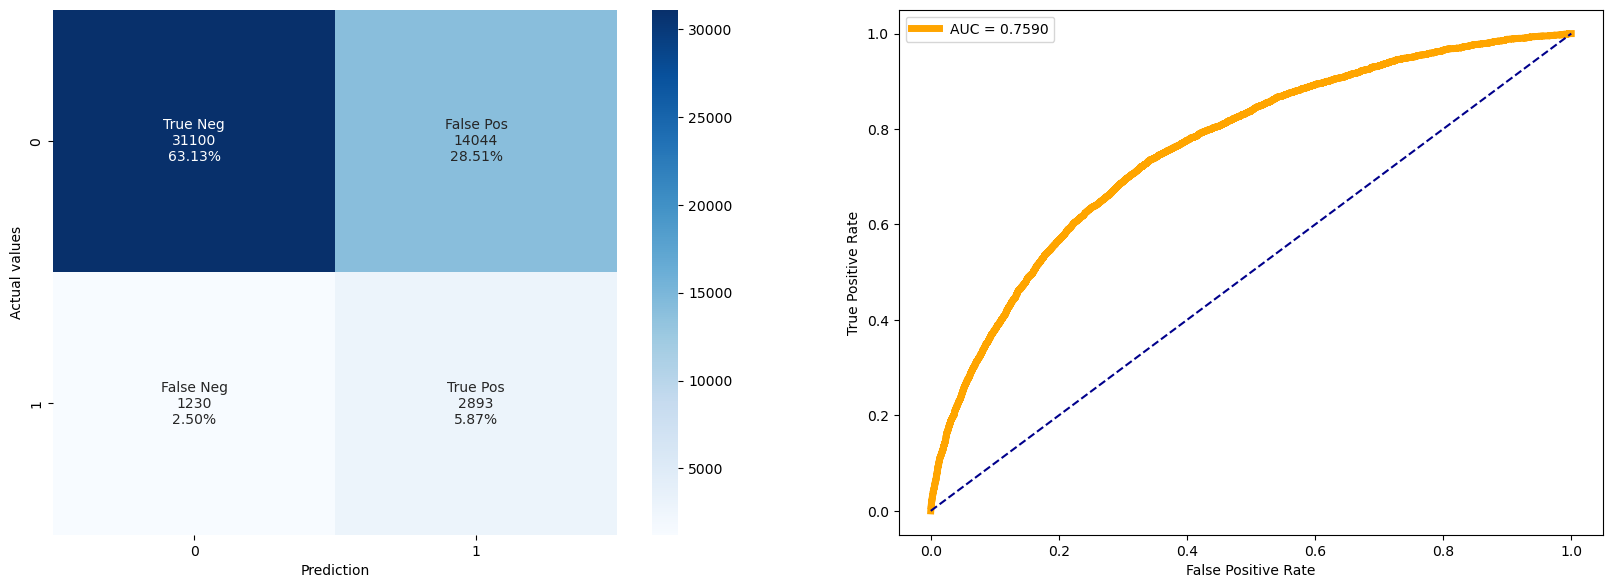

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.060000000000000005, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'min_data_in_leaf': 100}


In [76]:
# Under-sampling GS LGBMClassifier

X_train, X_test, y_train, y_test = train_test_split(df_train.loc[:, df_train.columns != 'TARGET'], df_train[['TARGET']])

X = pd.concat([X_train, y_train], axis=1)
class_count_0, class_count_1 = X['TARGET'].value_counts()
class_0 = X[X['TARGET'] == 0]
class_1 = X[X['TARGET'] == 1]

class_0_under = class_0.sample(class_count_1)
X = pd.concat([class_1, class_0_under], axis=0)
print('under_sampling :', X['TARGET'].value_counts()) 

X_train, y_train = X.loc[:, X.columns != 'TARGET'], X[['TARGET']]

parameters = {"min_data_in_leaf" : np.arange(20,120,10), "learning_rate" :  np.arange(0.01,0.10,0.01)}

model = LGBMClassifier()

clf = GridSearchCV(model, parameters, cv=3, scoring=fb)
clf.fit(X_train,y_train, eval_metric= 'auc')
GSmodel = clf.best_estimator_
y_predict = GSmodel.predict(X_test)
print(metrics.fbeta_score(y_test, y_predict, beta = 3))
roc_auc = roc_auc_score(y_test, GSmodel.predict_proba(X_test)[:,1])
cf_matrix_roc_auc(GSmodel, y_test,  y_predict, GSmodel.predict_proba(X_test)[:,1])
print(GSmodel.get_params())

In [77]:
#import joblib
#joblib.dump(GSmodel, 'model.pkl')

In [78]:
#from mlflow.models.signature import infer_signature
#import mlflow.sklearn

#mlflow.sklearn.save_model(GSmodel, 'mlflow_model')

### Interprétabilité locale

In [79]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(X_train.values, mode='classification', feature_names=X_train.columns.tolist())

explainer

In [80]:
idx = 50

explanation = explainer.explain_instance(np.array(X_test.iloc[idx]), GSmodel.predict_proba, num_features=len(X_test.columns))

print("Prediction : ", GSmodel.predict(np.array(X_test.iloc[idx]).reshape(-1, len(X_test.columns)))[0])
print("Actual :     ", y_test.iloc[idx])
print(explanation)

Prediction :  0.0
Actual :      TARGET    0.0
Name: 9983, dtype: category
Categories (2, float64): [0.0, 1.0]


In [81]:
explanation.show_in_notebook()

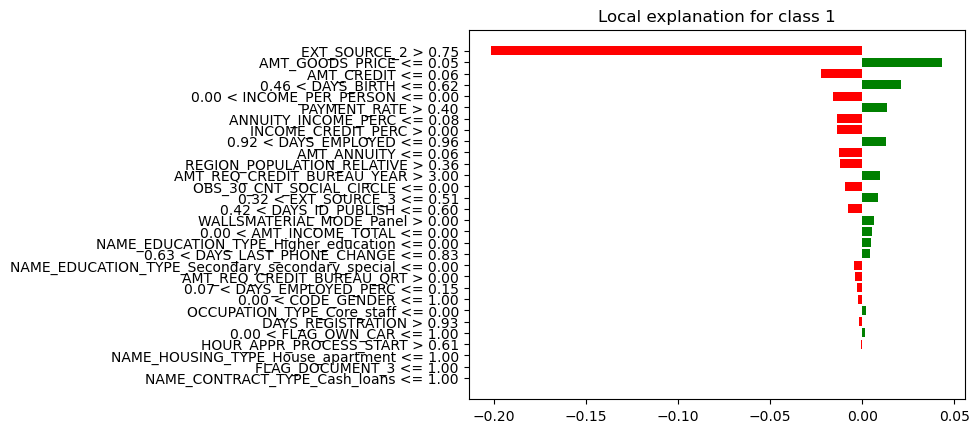

In [82]:
idx = 50
explanation = explainer.explain_instance(np.array(X_test.iloc[idx]), GSmodel.predict_proba, num_features=len(X_test.columns))
fig = explanation.as_pyplot_figure()
plt.show(fig)

In [83]:
import shap

# Calculate SHAP values for an observation
explainer = shap.TreeExplainer(GSmodel)
shap_values = explainer.shap_values(X_test.iloc[[50]])

# Visualize the decision tree explanation
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[[50]])


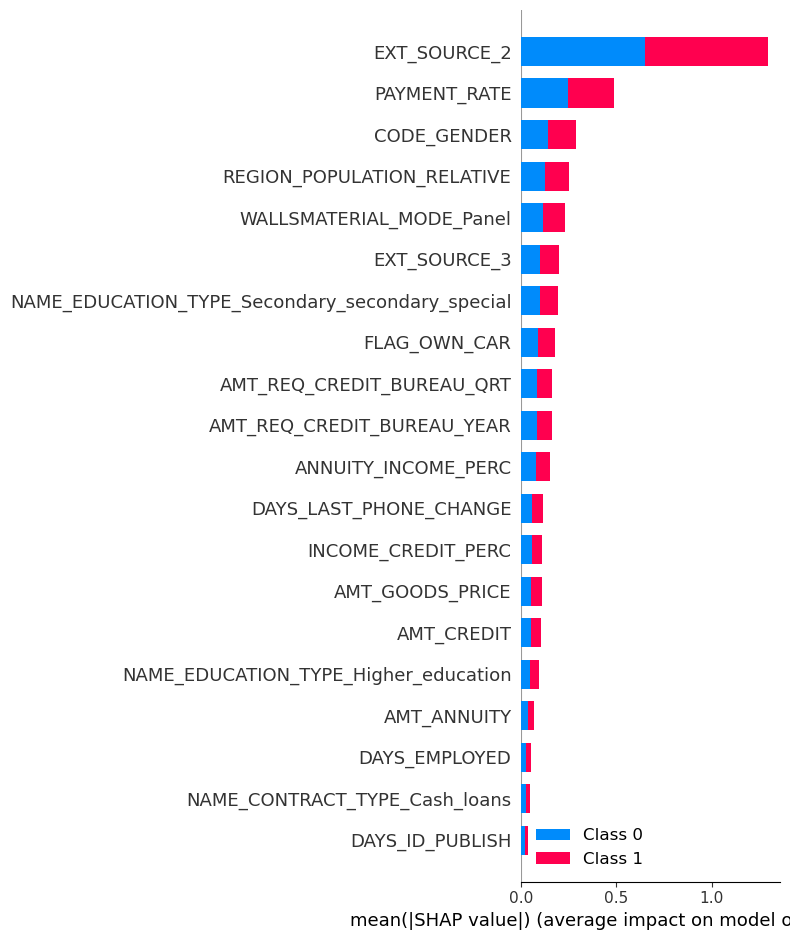

In [84]:
import shap
import matplotlib.pyplot as plt

# Calculate SHAP values for an observation
explainer = shap.TreeExplainer(GSmodel)
shap_values = explainer.shap_values(X_test.iloc[[50]])

# Summary plot
shap.summary_plot(shap_values, X_test.iloc[[50]], plot_type="bar")

# Force plot for the observation
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[[50]])
plt.show()


### Analyse data drift

L’analyse à l’aide d’evidently vous permettra de détecter éventuellement du Data Drift sur les principales features, entre les datas d’entraînement et les datas de production, au travers du tableau HTML d’analyse que vous aurez réalisé.

In [85]:
df_reference = df.loc[df['TARGET'].isna() == False]
df_current = df.loc[df['TARGET'].isna()]

In [86]:
df_reference.head(3)

SK_ID_CURR TARGET CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0      100002    1.0           0            0               0             0   
1      100003    0.0           1            0               1             0   
2      100004    0.0           0            1               0             0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          202500.0    406597.5      24700.5         351000.0   
1          270000.0   1293502.5      35698.5        1129500.0   
2           67500.0    135000.0       6750.0         135000.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461         -637.0            -3648.0   
1                    0.003541      -16765        -1188.0            -1186.0   
2                    0.010032      -19046         -225.0            -4260.0   

   DAYS_ID_PUBLISH FLAG_MOBIL FLAG_EMP_PHONE FLAG_WORK_PHONE FLAG_CONT_MOBILE  \
0            -2120          1              1               0                1   
1             -291          1              1               0                1   
2            -2531          1              1               1                1   

  FLAG_PHONE FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0          1          0              1.0                     2   
1          1          0              2.0                     1   
2          1          0              1.0                     2   

   REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                            2                       10   
1                            1                       11   
2                            2                        9   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_2  \
0                       0                        0      0.262949   
1                       0                        0      0.622246   
2                       0                        0      0.555912   

   EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
0      0.139376                       2.0                       2.0   
1           NaN                       1.0                       0.0   
2      0.729567                       0.0                       0.0   

   OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  DAYS_LAST_PHONE_CHANGE  \
0                       2.0                       2.0                 -1134.0   
1                       1.0                       0.0                  -828.0   
2                       0.0                       0.0                  -815.0   

  FLAG_DOCUMENT_2 FLAG_DOCUMENT_3 FLAG_DOCUMENT_4 FLAG_DOCUMENT_5  \
0               0               1               0               0   
1               0               1               0               0   
2               0               0               0               0   

  FLAG_DOCUMENT_6 FLAG_DOCUMENT_7 FLAG_DOCUMENT_8 FLAG_DOCUMENT_9  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   

  FLAG_DOCUMENT_10 FLAG_DOCUMENT_11 FLAG_DOCUMENT_12 FLAG_DOCUMENT_13  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   

  FLAG_DOCUMENT_14 FLAG_DOCUMENT_15 FLAG_DOCUMENT_16 FLAG_DOCUMENT_17  \


In [87]:
df_current.head(3)

SK_ID_CURR TARGET CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
307511      100001    NaN           1            0               0   
307512      100005    NaN           0            0               0   
307513      100013    NaN           0            1               0   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
307511             0          135000.0    568800.0      20560.5   
307512             0           99000.0    222768.0      17370.0   
307513             0          202500.0    663264.0      69777.0   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
307511         450000.0                    0.018850      -19241   
307512         180000.0                    0.035792      -18064   
307513         630000.0                    0.019101      -20038   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH FLAG_MOBIL  \
307511        -2329.0            -5170.0             -812          1   
307512        -4469.0            -9118.0            -1623          1   
307513        -4458.0            -2175.0            -3503          1   

       FLAG_EMP_PHONE FLAG_WORK_PHONE FLAG_CONT_MOBILE FLAG_PHONE FLAG_EMAIL  \
307511              1               0                1          0          1   
307512              1               0                1          0          0   
307513              1               0                1          0          0   

        CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
307511              2.0                     2                            2   
307512              2.0                     2                            2   
307513              2.0                     2                            2   

        HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
307511                       18                           0   
307512                        9                           0   
307513                       14                           0   

        REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
307511                           0                            0   
307512                           0                            0   
307513                           0                            0   

        REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
307511                       0                       0   
307512                       0                       0   
307513                       0                       0   

        LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_2  EXT_SOURCE_3  \
307511                        0      0.789654      0.159520   
307512                        0      0.291656      0.432962   
307513                        0      0.699787      0.610991   

        OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
307511                       0.0                       0.0   
307512                       0.0                       0.0   
307513                       0.0                       0.0   

        OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  \
307511                       0.0                       0.0   
307512                       0.0                       0.0   
307513                       0.0                       0.0   

        DAYS_LAST_PHONE_CHANGE FLAG_DOCUMENT_2 FLAG_DOCUMENT_3  \
307511                 -1740.0               0               1   
307512                     0.0               0               1   
307513                  -856.0               0               0   

       FLAG_DOCUMENT_4 FLAG_DOCUMENT_5 FLAG_DOCUMENT_6 FLAG_DOCUMENT_7  \
307511               0               0               0               0   
307512               0               0               0               0   
307513               0               0               0               0   

       FLAG_DOCUMENT_8 FLAG_DOCUMENT_9 FLAG_DOCUMENT_10 FLAG_DOCUMENT_11  \
307511               0               0                0                0   
307512               0               0        

In [88]:
df_reference = df_reference.drop(['SK_ID_CURR','TARGET'], axis=1)

In [89]:
df_current = df_current.drop(['SK_ID_CURR','TARGET'], axis=1)

In [90]:
df_reference, mms = preprocessing(df_reference)

(201088, 200)


In [91]:
df_current, mms = preprocessing(df_current)

(32323, 200)


In [92]:
df_reference = df_reference.astype(float)

In [93]:
df_current = df_current.astype(float)

In [94]:
reference = df_reference.sample(n=5000, random_state=42)

In [95]:
current = df_current.sample(n=5000, random_state=42)

In [96]:
print(reference.shape, current.shape)

(5000, 200) (5000, 200)


In [97]:
reference = reference[['PAYMENT_RATE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 'DAYS_EMPLOYED_PERC', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'ANNUITY_INCOME_PERC', 'INCOME_CREDIT_PERC', 'AMT_CREDIT',
       'INCOME_PER_PERSON', 'AMT_INCOME_TOTAL', 'HOUR_APPR_PROCESS_START',
       'CODE_GENDER', 'NAME_EDUCATION_TYPE_Higher_education',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'FLAG_OWN_CAR', 'FLAG_DOCUMENT_3', 'NAME_CONTRACT_TYPE_Cash_loans',
       'OBS_30_CNT_SOCIAL_CIRCLE',
       'NAME_EDUCATION_TYPE_Secondary_secondary_special',
       'WALLSMATERIAL_MODE_Panel', 'NAME_HOUSING_TYPE_House_apartment',
       'OCCUPATION_TYPE_Core_staff']]

In [98]:
current = current[['PAYMENT_RATE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 'DAYS_EMPLOYED_PERC', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'ANNUITY_INCOME_PERC', 'INCOME_CREDIT_PERC', 'AMT_CREDIT',
       'INCOME_PER_PERSON', 'AMT_INCOME_TOTAL', 'HOUR_APPR_PROCESS_START',
       'CODE_GENDER', 'NAME_EDUCATION_TYPE_Higher_education',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'FLAG_OWN_CAR', 'FLAG_DOCUMENT_3', 'NAME_CONTRACT_TYPE_Cash_loans',
       'OBS_30_CNT_SOCIAL_CIRCLE',
       'NAME_EDUCATION_TYPE_Secondary_secondary_special',
       'WALLSMATERIAL_MODE_Panel', 'NAME_HOUSING_TYPE_House_apartment',
       'OCCUPATION_TYPE_Core_staff']]

In [99]:
print(reference.shape, current.shape)

(5000, 30) (5000, 30)


In [100]:
import evidently

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics.base_metric import generate_column_metrics
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset, DataQualityPreset, RegressionPreset
from evidently.test_suite import TestSuite
from evidently.tests.base_test import generate_column_tests
from evidently.test_preset import DataStabilityTestPreset, NoTargetPerformanceTestPreset, RegressionTestPreset

In [101]:
data_drift_report = Report(metrics=[DataDriftPreset()])

data_drift_report.run(current_data=current, reference_data=reference, column_mapping=None)

In [102]:
data_drift_report.save_html("data_drift.html")

In [103]:
suite = TestSuite(tests=[
    NoTargetPerformanceTestPreset(),
])

suite.run(reference_data=reference , current_data=current)

In [104]:
suite.save_html("suite_data_drift.html")